# Importing Libraries

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
SMALL_SIZE = 18
MEDIUM_SIZE = 26
BIGGER_SIZE = 30
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
import copy
import random
from scipy.stats import t
fig_res = (24,16)
random.seed(42)


CI_SAMPLE_SIZE = 50
# Confidence Interval calculation
def confidence_interval(simulation_results, confidence=0.95, output_results=True):
    mean = np.mean(simulation_results)
    std = np.std(simulation_results)
    degree = len(simulation_results) - 1 
    t_crit = np.abs(t.ppf((1-confidence)/2, degree))    # Find the inverse cumulative distribution.
    ci = std*t_crit/np.sqrt(len(simulation_results))
    if output_results:
        print("Average waiting time is: ", mean)
        conf_int_low = mean-ci
        conf_int_high = mean+ci
        print("With the Confidence Interval: ", conf_int_low, conf_int_high)
        print("Confidence Interval Size: ", conf_int_high-conf_int_low)
        return
    else: return mean, ci

# Visualization of Average Results with CI from Simulations
def visualize_conf_interval(means, std, title, xlabel, ylabel, mc_chains=0, mc_chain_size=0):
    lower = np.subtract(means, std)
    upper = np.add(means, std)

    plt.figure(figsize=fig_res)
    plt.plot(means,'royalblue', label='Mean', linewidth=0.8)
    plt.plot(upper,'orange', label='Upper Boundary of CI', linewidth=0.3)
    plt.plot(lower,'darkorange', label='Lower Boundary of CI', linewidth=0.3)

    if (mc_chains!=0 or mc_chain_size!=0):
        temperature_changes = np.arange(0, mc_chains*mc_chain_size, mc_chain_size)
        for line in temperature_changes:
            plt.axvline(x=line, linewidth=0.1)

    plt.fill_between(list(range(len(means))), upper, lower, color="k", alpha=0.1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    return

# Box plot for array of results from simulation
def box_plot(data, title, x_axis, x_axis_ticks, y_axis):
    fig, ax = plt.subplots(figsize = fig_res)
    ax.boxplot(data)
    ax.set_xticklabels(x_axis_ticks)
    fig.suptitle(title)
    plt.yscale('linear')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.show()


# Class that represents a city (2D point)
class City:
    id: int
    x: float
    y: float

    def __init__(self, id, x, y):
        self.x = float(x)
        self.y = float(y)
        self.id = int(id)

# Reading File

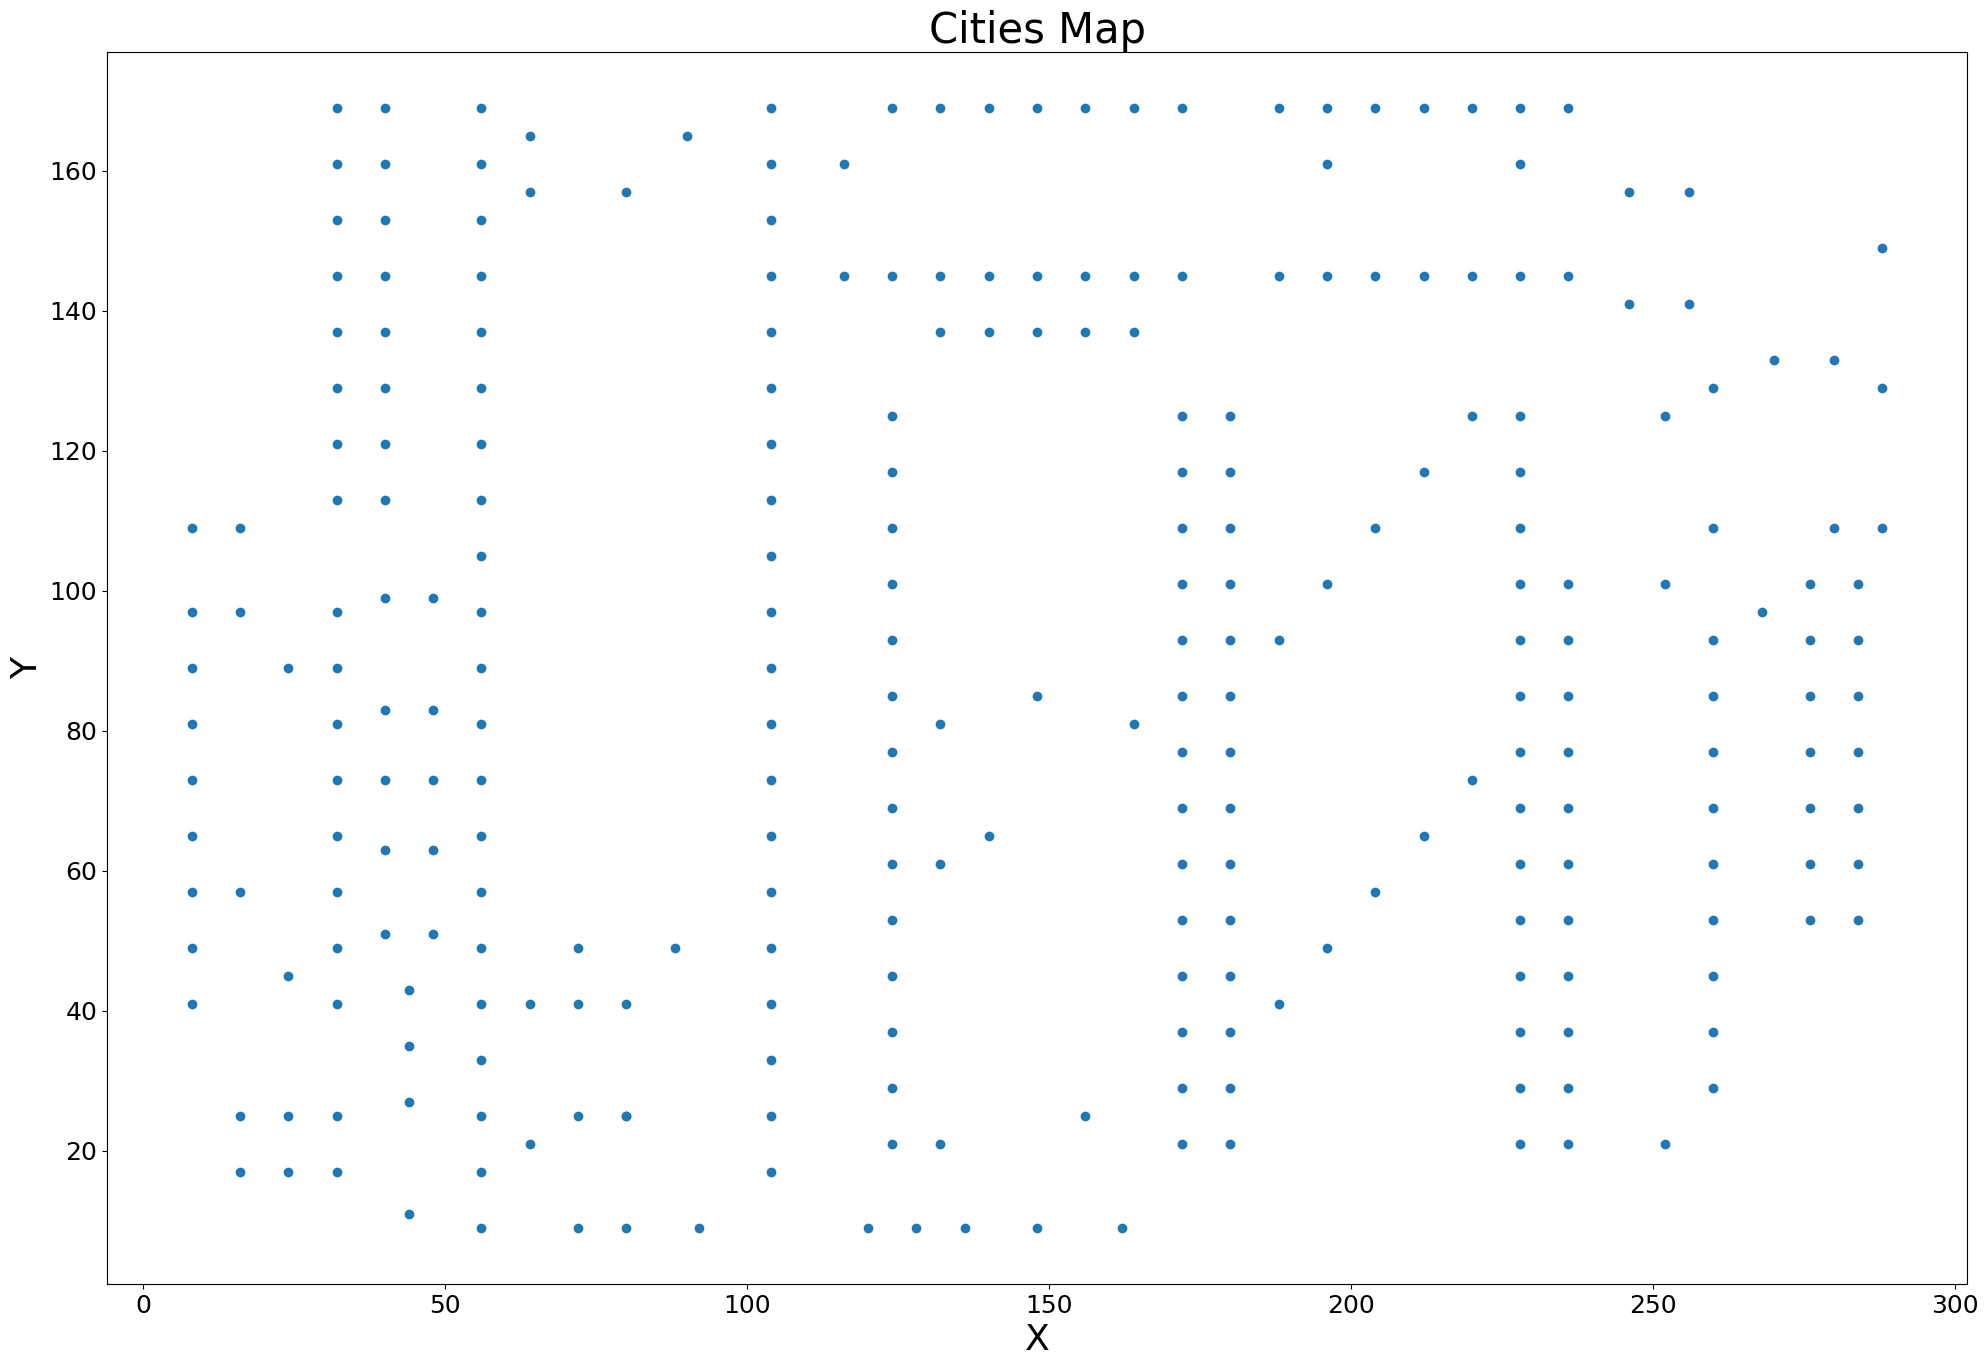

In [2]:
# Solving correct problem
problem_size = "medium"

if problem_size == "small":
    # File name of the problem
    file_name = "eil51.tsp.txt"
    # File Structure
    intro_lines = 6
    cities_amount = 51
elif problem_size == "medium":
    # File name of the problem
    file_name = "a280.tsp.txt"
    # File Structure
    intro_lines = 6
    cities_amount = 280
elif problem_size == "large":
    # File name of the problem
    file_name = "pcb442.tsp.txt"
    # File Structure
    intro_lines = 6
    cities_amount = 442


cities = []
with open(file_name,"r") as f:
    for i in range(intro_lines):
        f.readline()
    for i in range(cities_amount):
        line = f.readline()
        id, x, y = line.split()
        cities.append(City(id, x, y))

coordinates_x = []
coordinates_y = []
for City in cities:
    coordinates_x.append(City.x)
    coordinates_y.append(City.y)
plt.figure(figsize=fig_res)
plt.title("Cities Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(coordinates_x, coordinates_y)

# Solving Traveling Salesman Problem

Init Path
Random path's distance:  34434.84526951124


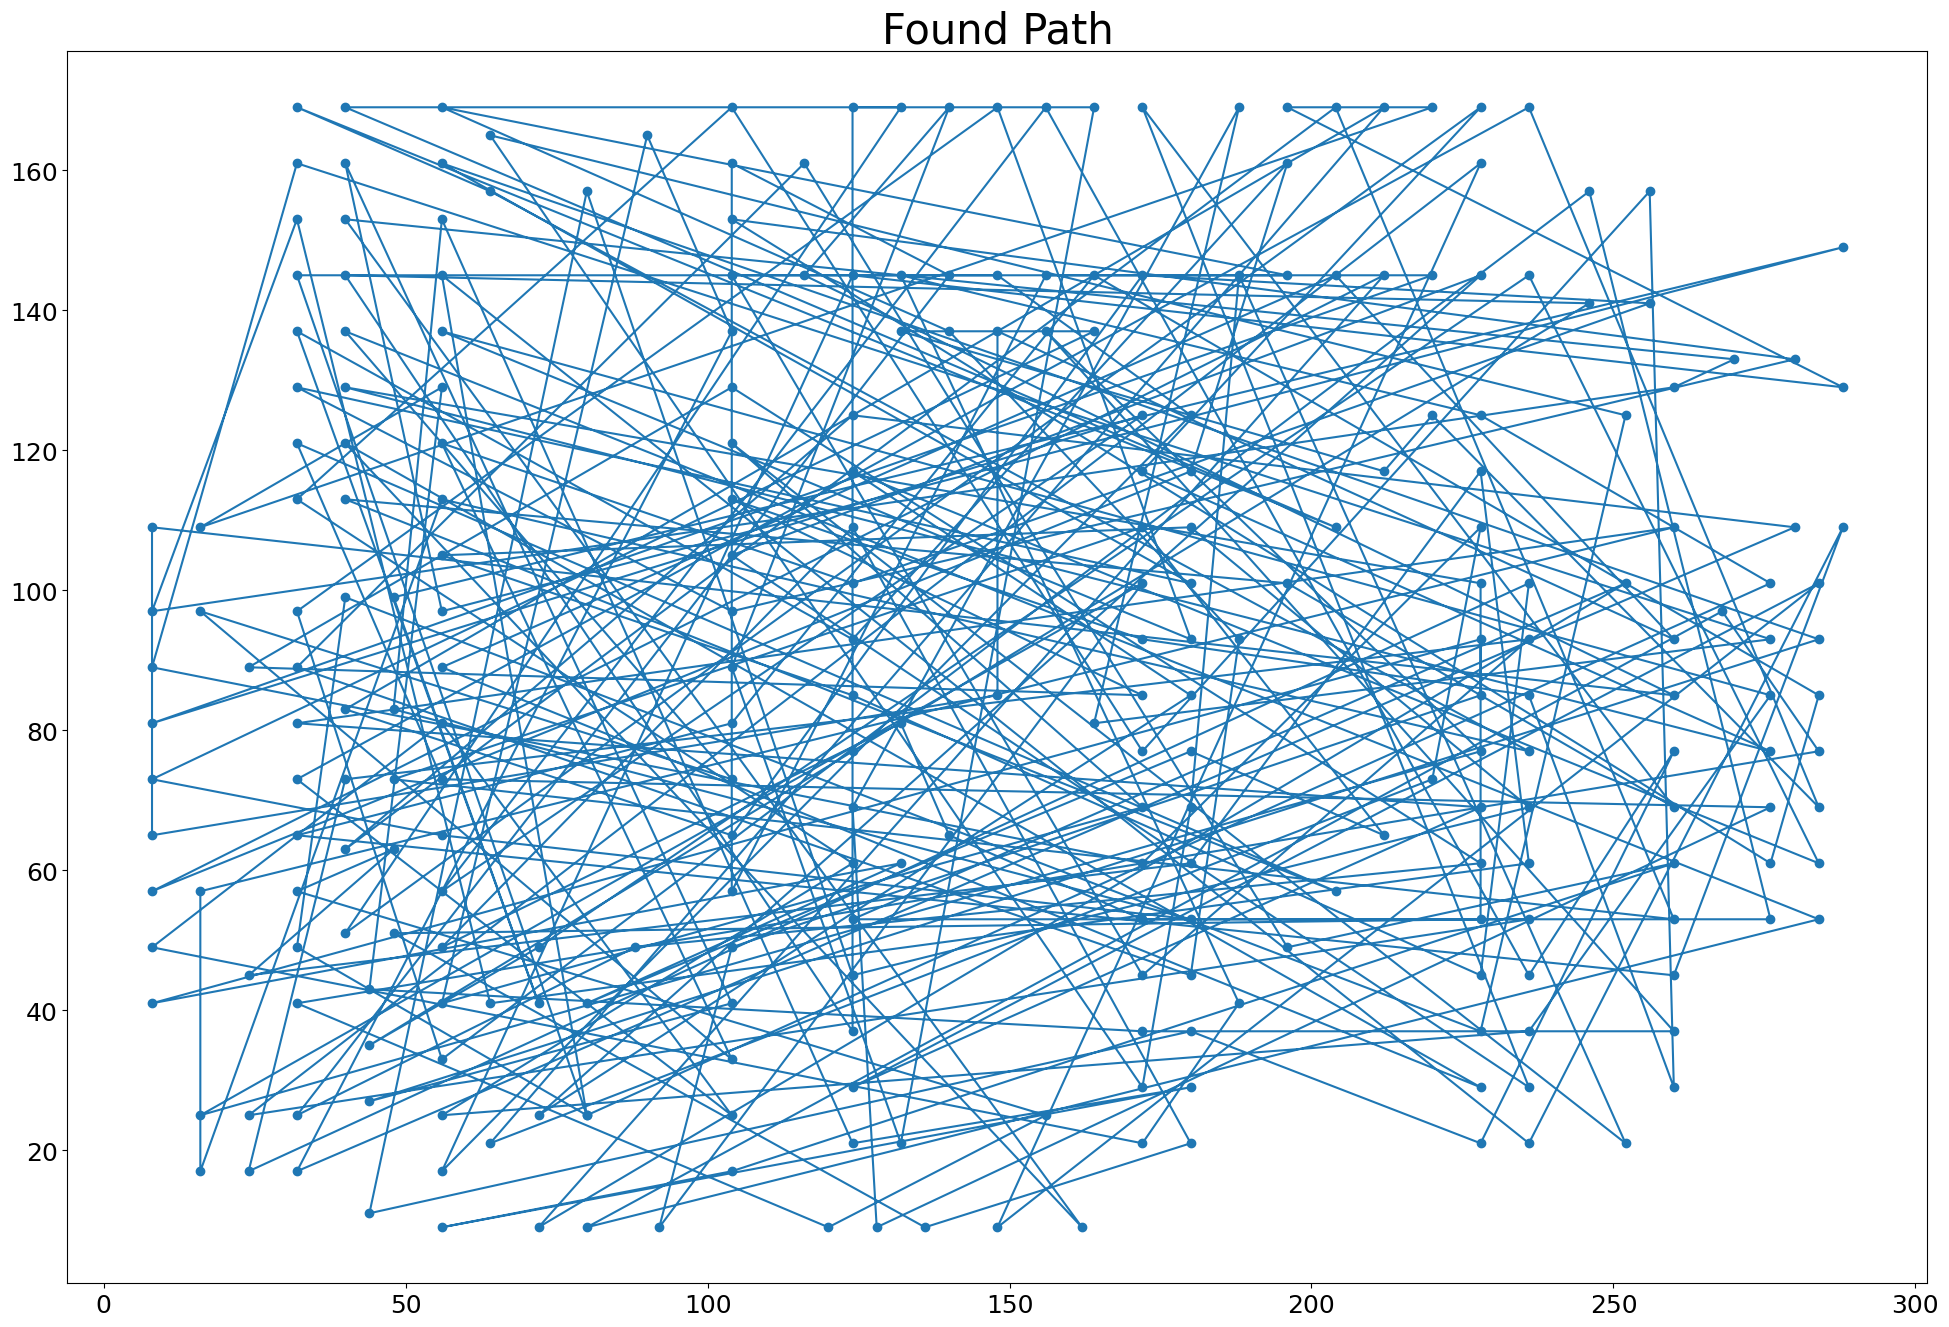

In [3]:
# Creating class for a path
class Path:
    city_ids = []

    def __init__(self, city_ids = []):
        self.city_ids = copy.deepcopy(city_ids)

    # Finds overall size of the path with Euclidean Distance (Fitness Function)
    def eval_distance(self):
        distance = 0
        for i in range(len(self.city_ids)-1):            
            # Because cities ids are starting from 1, and array starts at 0
            distance += np.sqrt(
            (cities[self.city_ids[i+1]-1].x - cities[self.city_ids[i]-1].x)**2 + 
            (cities[self.city_ids[i+1]-1].y - cities[self.city_ids[i]-1].y)**2 )
        return distance

    # Path is invalid if returned to non starting location at the end
    def eval_validity(self):
        if self.city_ids[0] == self.city_ids[-1]:
            return True
        else: return False

    # Visualize Path
    def visualize(self):
        coordinates_x = []
        coordinates_y = []
        for i in self.city_ids:
            coordinates_x.append(cities[i-1].x)       # Because cities ids are starting from 1, and array starts at 0
            coordinates_y.append(cities[i-1].y)
        plt.figure(figsize=fig_res)
        plt.scatter(coordinates_x, coordinates_y)
        plt.title("Found Path")
        plt.plot(coordinates_x, coordinates_y)
        plt.show()
    # Print Path
    def visualize_print(self):
        print(self.city_ids)

    # Generating new paths
    # Random Permutations, k=amount of swaps
    def generate_new_path_random_swapping(self, k):
        city_ids_new = copy.deepcopy(self.city_ids)

        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k*2)   # We are not swapping start and end
        ids_to_swap.sort()

        for j in range(0, k, 2):
            city_ids_new[ids_to_swap[j]], city_ids_new[ids_to_swap[j+1]] = city_ids_new[ids_to_swap[j+1]], city_ids_new[ids_to_swap[j]]
        return Path(city_ids_new)
    # Inserting of vertices, k=amount of inserts
    # Take a vertex, place it in a location, shift other
    def generate_new_path_insertting(self, k):
        city_ids_new = copy.deepcopy(self.city_ids)

        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k*2)   # We are not swapping start and end
        ids_to_swap.sort()

        for j in range(0, k, 2):
            # Saving Value
            insert_value = city_ids_new[ids_to_swap[j+1]]
            # Shifting
            city_ids_new[ids_to_swap[j]+1:ids_to_swap[j+1]+1] = city_ids_new[ids_to_swap[j]:ids_to_swap[j+1]] 
            # Inserting
            city_ids_new[ids_to_swap[j]] = insert_value
        return Path(city_ids_new)
    # k-Opt
    def generate_new_path_k_opt(self, k):
        city_ids_new = copy.deepcopy(self.city_ids)

        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k)   # We are not swapping start and end, they will be swapped if we change id: 1 and N-1
        while len(np.unique(ids_to_swap)) != len(ids_to_swap):
            ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k)
        ids_to_swap.sort()

        for j in range(k-1):
            city_ids_new[ids_to_swap[j]:ids_to_swap[j+1]] = reversed(city_ids_new[ids_to_swap[j]:ids_to_swap[j+1]])
        return Path(city_ids_new)

def generate_initial_random_path(cities):
    # Generating some initial guess for the Path (Simplest way to create initial guess is just to shuffle)
    shuffled = sorted(cities, key=lambda k: random.random())
    shuffled.append(shuffled[0])    # So that path is cycle
    city_ids_init_path = []
    for city in shuffled:
        city_ids_init_path.append(city.id)
    initial_path = Path(city_ids_init_path)
    return initial_path

initial_path = generate_initial_random_path(cities)
print("Init Path")
print("Random path's distance: ", initial_path.eval_distance())     # Evaluate circuit size
initial_path.visualize()                # And see it

# Simulated Annealing

## Cooling Functions

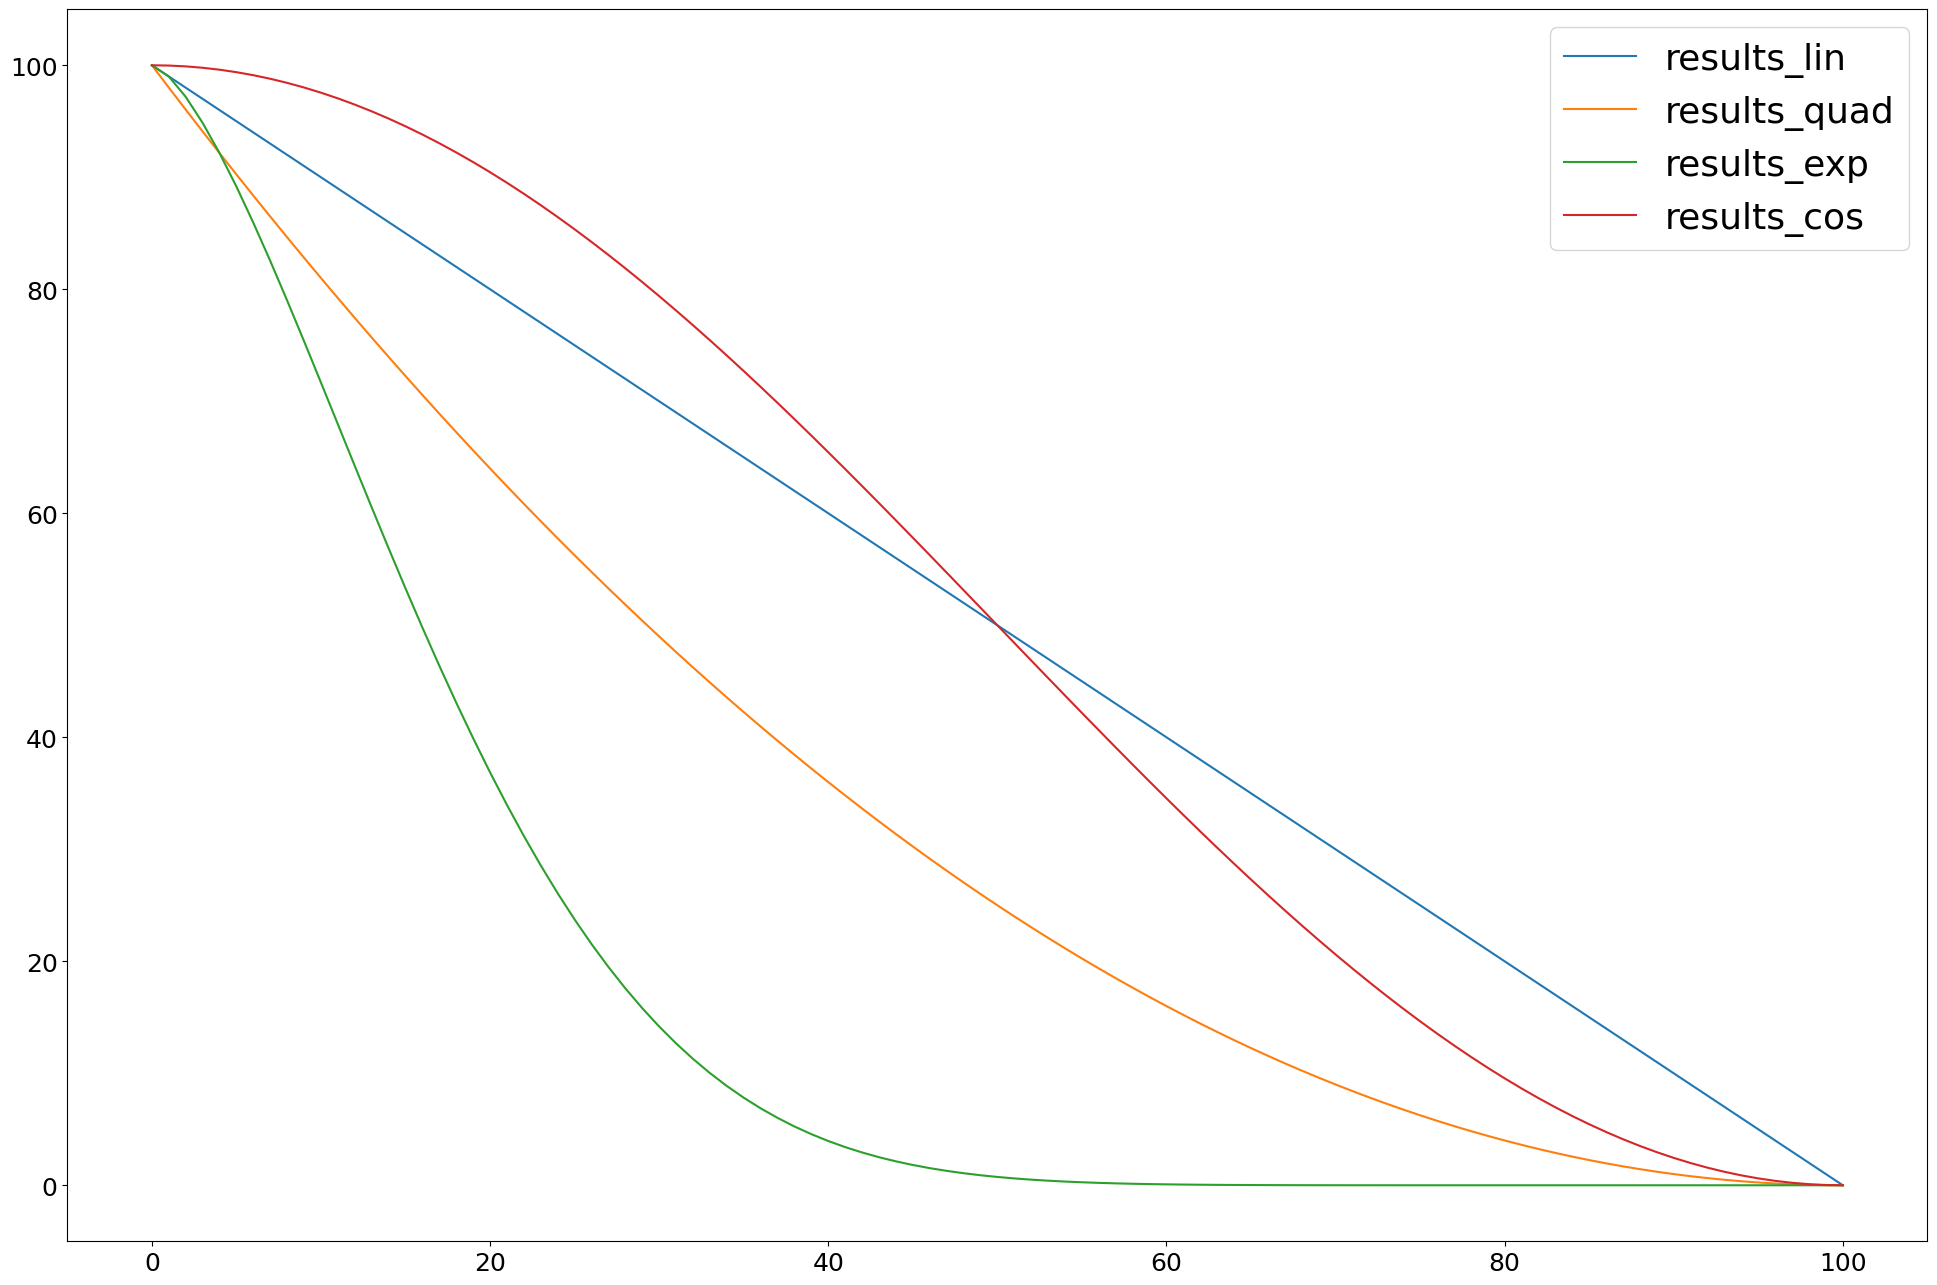

In [4]:
# Cooling Functions

# no alpha, goes to temp_min gradually
# http://what-when-how.com/artificial-intelligence/a-comparison-of-cooling-schedules-for-simulated-annealing-artificial-intelligence/
def cool_lin_a(temp_min, temp_max, outer_loop, step):
    return temp_min + (temp_max - temp_min) * ((outer_loop - step)/outer_loop)
def cool_quad_a(temp_min, temp_max, outer_loop, step):
    return temp_min + (temp_max - temp_min) * ((outer_loop - step)/outer_loop)**2
def cool_exp_a(temp_min, temp_max, outer_loop, step):
    return temp_min + (temp_max - temp_min) * ((outer_loop - step)/outer_loop)**np.sqrt(step)
def cool_cos_a(temp_min, temp_max, outer_loop, step):
    return temp_min + 0.5*(temp_max - temp_min) * (1 + np.cos(step*np.pi/outer_loop))

temp_min = 0
temp_max = 100
temp = temp_max
outer_loop = 100

results_lin = []
results_quad = []
results_exp = []
results_cos = []

for step in range(outer_loop+1):
    results_lin.append(cool_lin_a(temp_min, temp_max, outer_loop, step))
    results_quad.append(cool_quad_a(temp_min, temp_max, outer_loop, step))
    results_exp.append(cool_exp_a(temp_min, temp_max, outer_loop, step))
    results_cos.append(cool_cos_a(temp_min, temp_max, outer_loop, step))

plt.figure(figsize=fig_res)
plt.plot(results_lin, label="results_lin")
plt.plot(results_quad, label="results_quad")
plt.plot(results_exp, label="results_exp")
plt.plot(results_cos, label="results_cos")
plt.legend()
plt.show()

## Simulated Annealing (Homogenous MC)

In [8]:
# Simulated Annealing
def annealing_solution_homogenous(search_method, k, init_path, inner_loop, outer_loop, cooling_func, exploration, visualize_results):
    """
    Parameters:
        inner_loop - Metropolis steps (Each Monte Carlo chain's size)
        outer_loop - # Amount of Monte Carlo chains
        exploration - if True, sets Initial temperature high (average size of the initial path). If False, sets temperature low (sqrt of average)
        cooling_func - exp, quad, cos, lin
    """

    best_path = init_path
    current_path = init_path
    current_energy = init_path.eval_distance()

    chain_step = 0
    initial_path = generate_initial_random_path(cities)
    
    # Cooling Schedules
    if exploration:
        temp_max = initial_path.eval_distance()/cities_amount   # Average path size in the beginning is a good guess, as it is close to the first possible optimization
    else:
        temp_max = np.sqrt(initial_path.eval_distance()/cities_amount)   # Average path size in the beginning is a good guess, as it is close to the first possible optimization
    temp_current = temp_max
    temperature_history = []    # Temperature history
    temperature_history.append(temp_current)
    if (visualize_results):
        print("Simulated Annealing Solution")
        print("Initial Temperature:", temp_max, ". Which constitutes a chance for accepting a 5% worse solution of ", 100*np.exp(-(0.05*current_energy) / temp_current), "%")

    solutions_history = []    # Energy of solutions history
    worse_sols = 0  # Keeping up with the amount of worse solutions accepted

    # Annealing Schedule
    # We will run until we go through all MC chains
    
    #for chain_step in tqdm(range(outer_loop), desc ="Progress of running MC chains"):
    for chain_step in (range(outer_loop)):

        chain_step += 1      # Stepping Outer Loop
        metropolis_step = 0  # Step of Inner Loop

        while metropolis_step < inner_loop:

            metropolis_step += 1

            # Get candidate solution
            if search_method == "random":
                candidate_path = current_path.generate_new_path_random_swapping(k) # k = Amount of swaps
            elif search_method == "insert":
                candidate_path = current_path.generate_new_path_insertting(k)      # k = Amount of inserts
            elif search_method == "k-opt":
                candidate_path = current_path.generate_new_path_k_opt(k)           # k = amount of rewires

            # Checking the candidate solution
            candidate_energy = candidate_path.eval_distance()
            delta_energy = candidate_energy - current_energy    # if solution is better, it is always accepted
            # If solution is better we accept it
            # If it is not, we accept it depending on the current temp
            if np.random.random() < np.exp(-delta_energy / temp_current):
                if delta_energy <= 0:            # Updating best soution (if applicable)
                    best_path = candidate_path
                else:
                    worse_sols += 1
                current_energy = candidate_energy
                current_path = candidate_path
            solutions_history.append(candidate_energy)
        
        # Cooling Function
        if cooling_func == "exp":
            temp_current = cool_exp_a(0, temp_max, outer_loop, chain_step)
        elif cooling_func == "quad":
            temp_current = cool_quad_a(0, temp_max, outer_loop, chain_step)
        elif cooling_func == "cos":
            temp_current = cool_cos_a(0, temp_max, outer_loop, chain_step)
        elif cooling_func == "lin":
            temp_current = cool_lin_a(0, temp_max, outer_loop, chain_step)
        temperature_history.append(temp_current)


    # Generate some final stats
    if visualize_results:
        print("Temperature History", temperature_history)
        print("Shortest found path is: ", best_path.eval_distance())     # Evaluate circuit size
        print("Inferior solutions accepted: ", worse_sols)
        best_path.visualize()                # And see it

    return best_path, solutions_history

## SA test: Init Temp

Don't forget about init temp, chance of accepting

### With Exploration

Progress of running samples for CI:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\pmchrist\AppData\Local\Temp\ipykernel_22116\1531784266.py:59: RuntimeWarning: overflow encountered in exp
  if np.random.random() < np.exp(-delta_energy / temp_current):
Generating Visualization of Paths: 100%|██████████| 100000/100000 [00:10<00:00, 9227.07it/s]



Best found paths length:  (3520.7388036248144, 33.79658256884795)


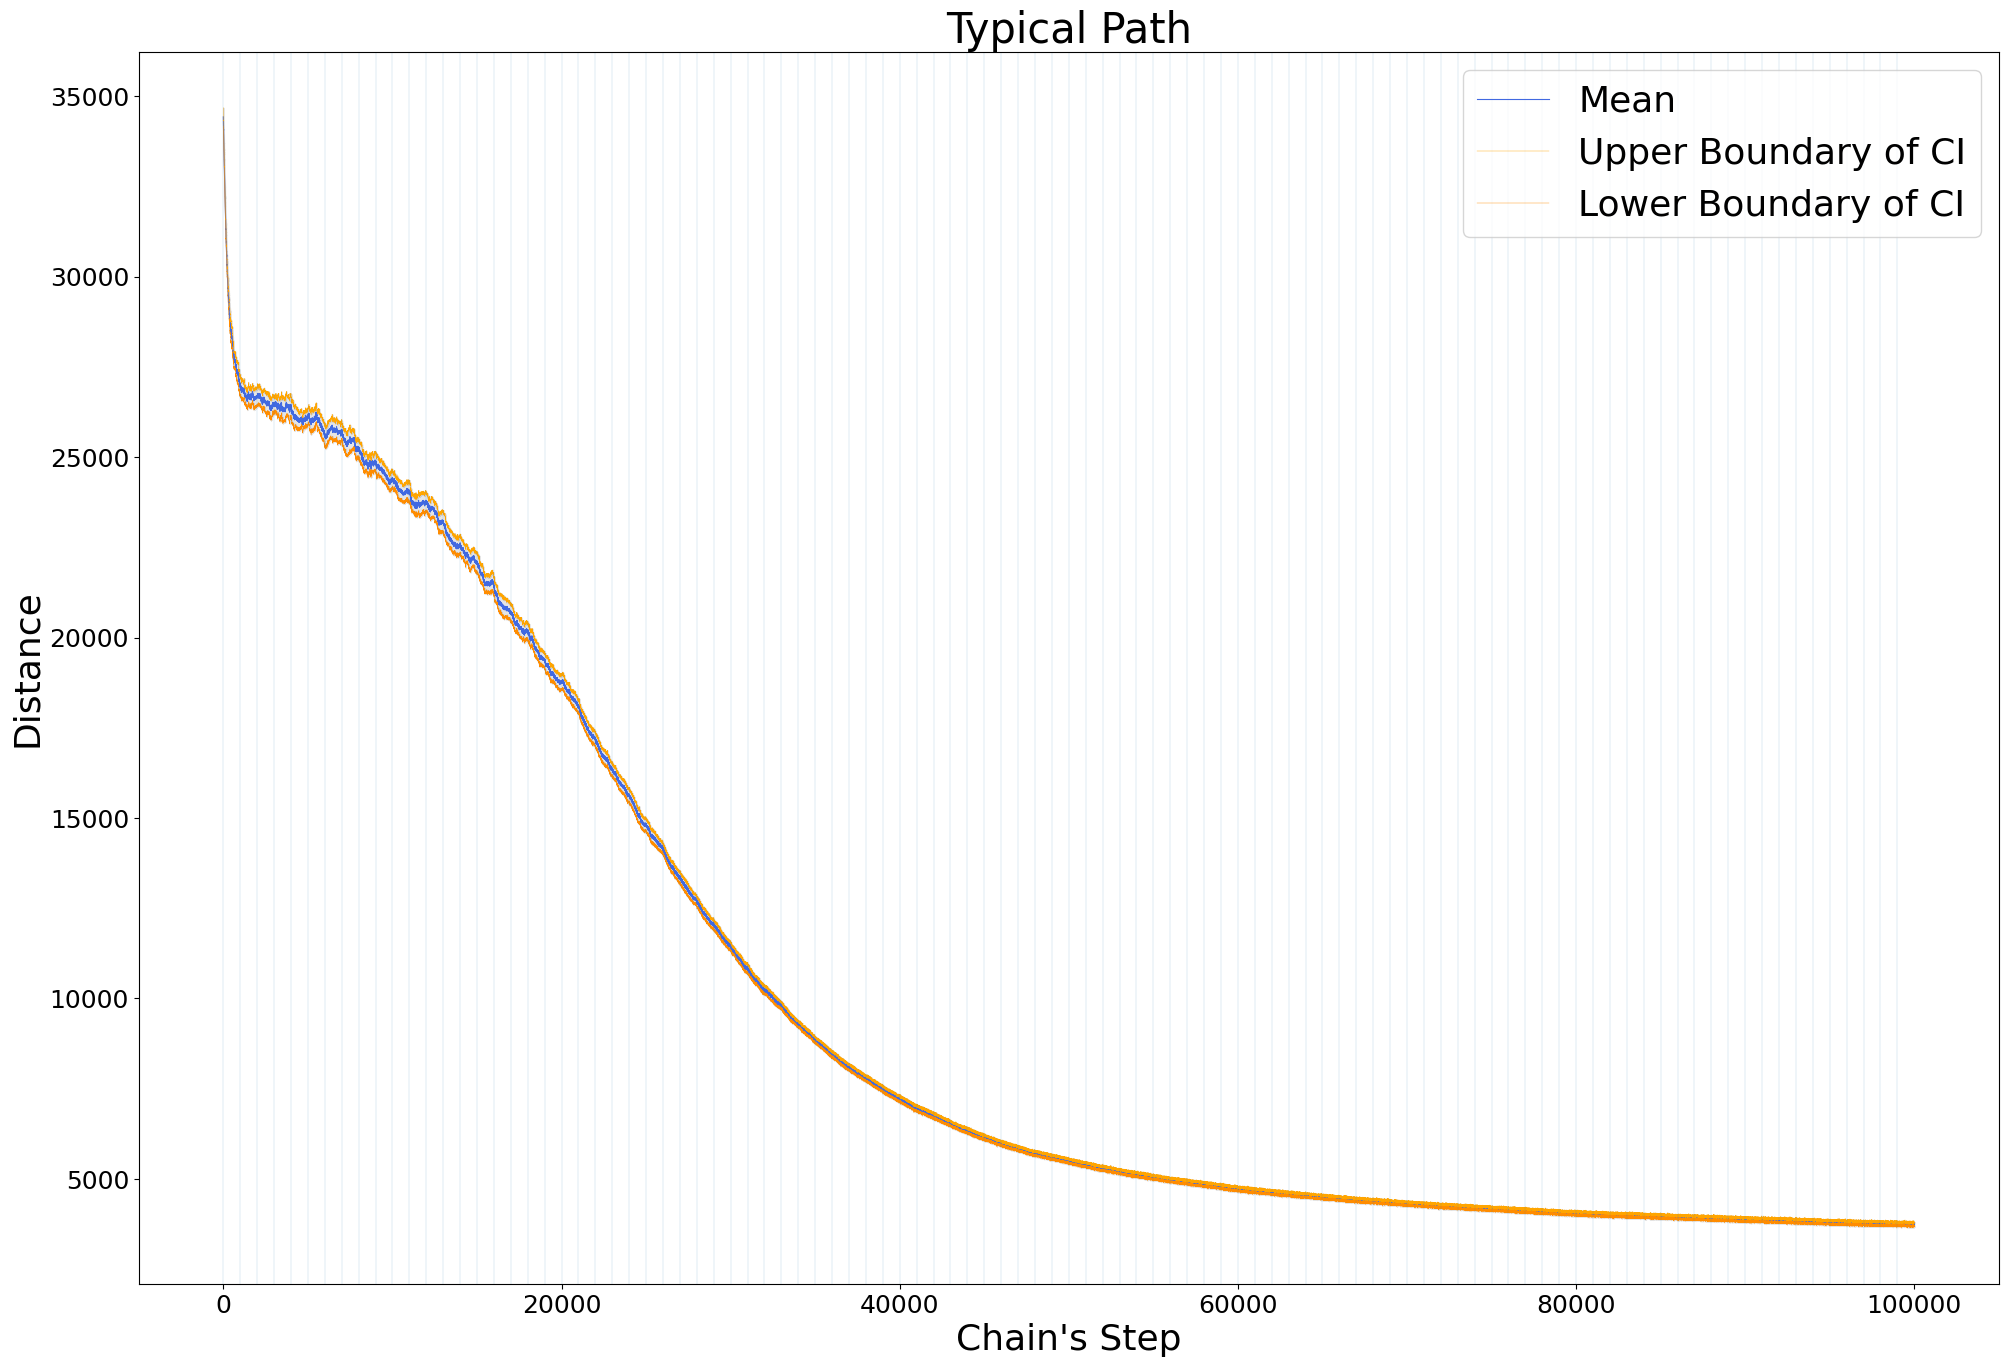

In [9]:
# With Exploration Exponential

# Generating Solution
mc_chains = 100
mc_chain_size = 1000

history_chain_solutions = []
history_best_solutions = []
for i in tqdm(range(CI_SAMPLE_SIZE), desc ="Progress of running samples for CI"):
    best_sol, all_sol = annealing_solution_homogenous("k-opt", 2, generate_initial_random_path(cities), mc_chain_size, mc_chains, "exp", True, False)
    history_best_solutions.append(best_sol.eval_distance())
    history_chain_solutions.append(all_sol)

# For visualization we need to Transpose results to find confidence intervals on each step
history_chain_solutions_T = np.array(history_chain_solutions).T
conf_means = []
conf_stds = []
for i in tqdm(range(len(history_chain_solutions_T)), desc ="Generating Visualization of Paths"):
    mean, std = confidence_interval(history_chain_solutions_T[i], 0.95, False)
    conf_means.append(mean)
    conf_stds.append(std)

print("\nBest found paths length: ", confidence_interval(history_best_solutions, 0.95, False))
visualize_conf_interval(conf_means, conf_stds, "Typical Path", "Chain's Step", "Distance", mc_chains, mc_chain_size)

Generating Visualization of Paths: 100%|██████████| 100000/100000 [00:10<00:00, 9283.00it/s]



Best found paths length:  (6087.042759313742, 62.66008511037037)


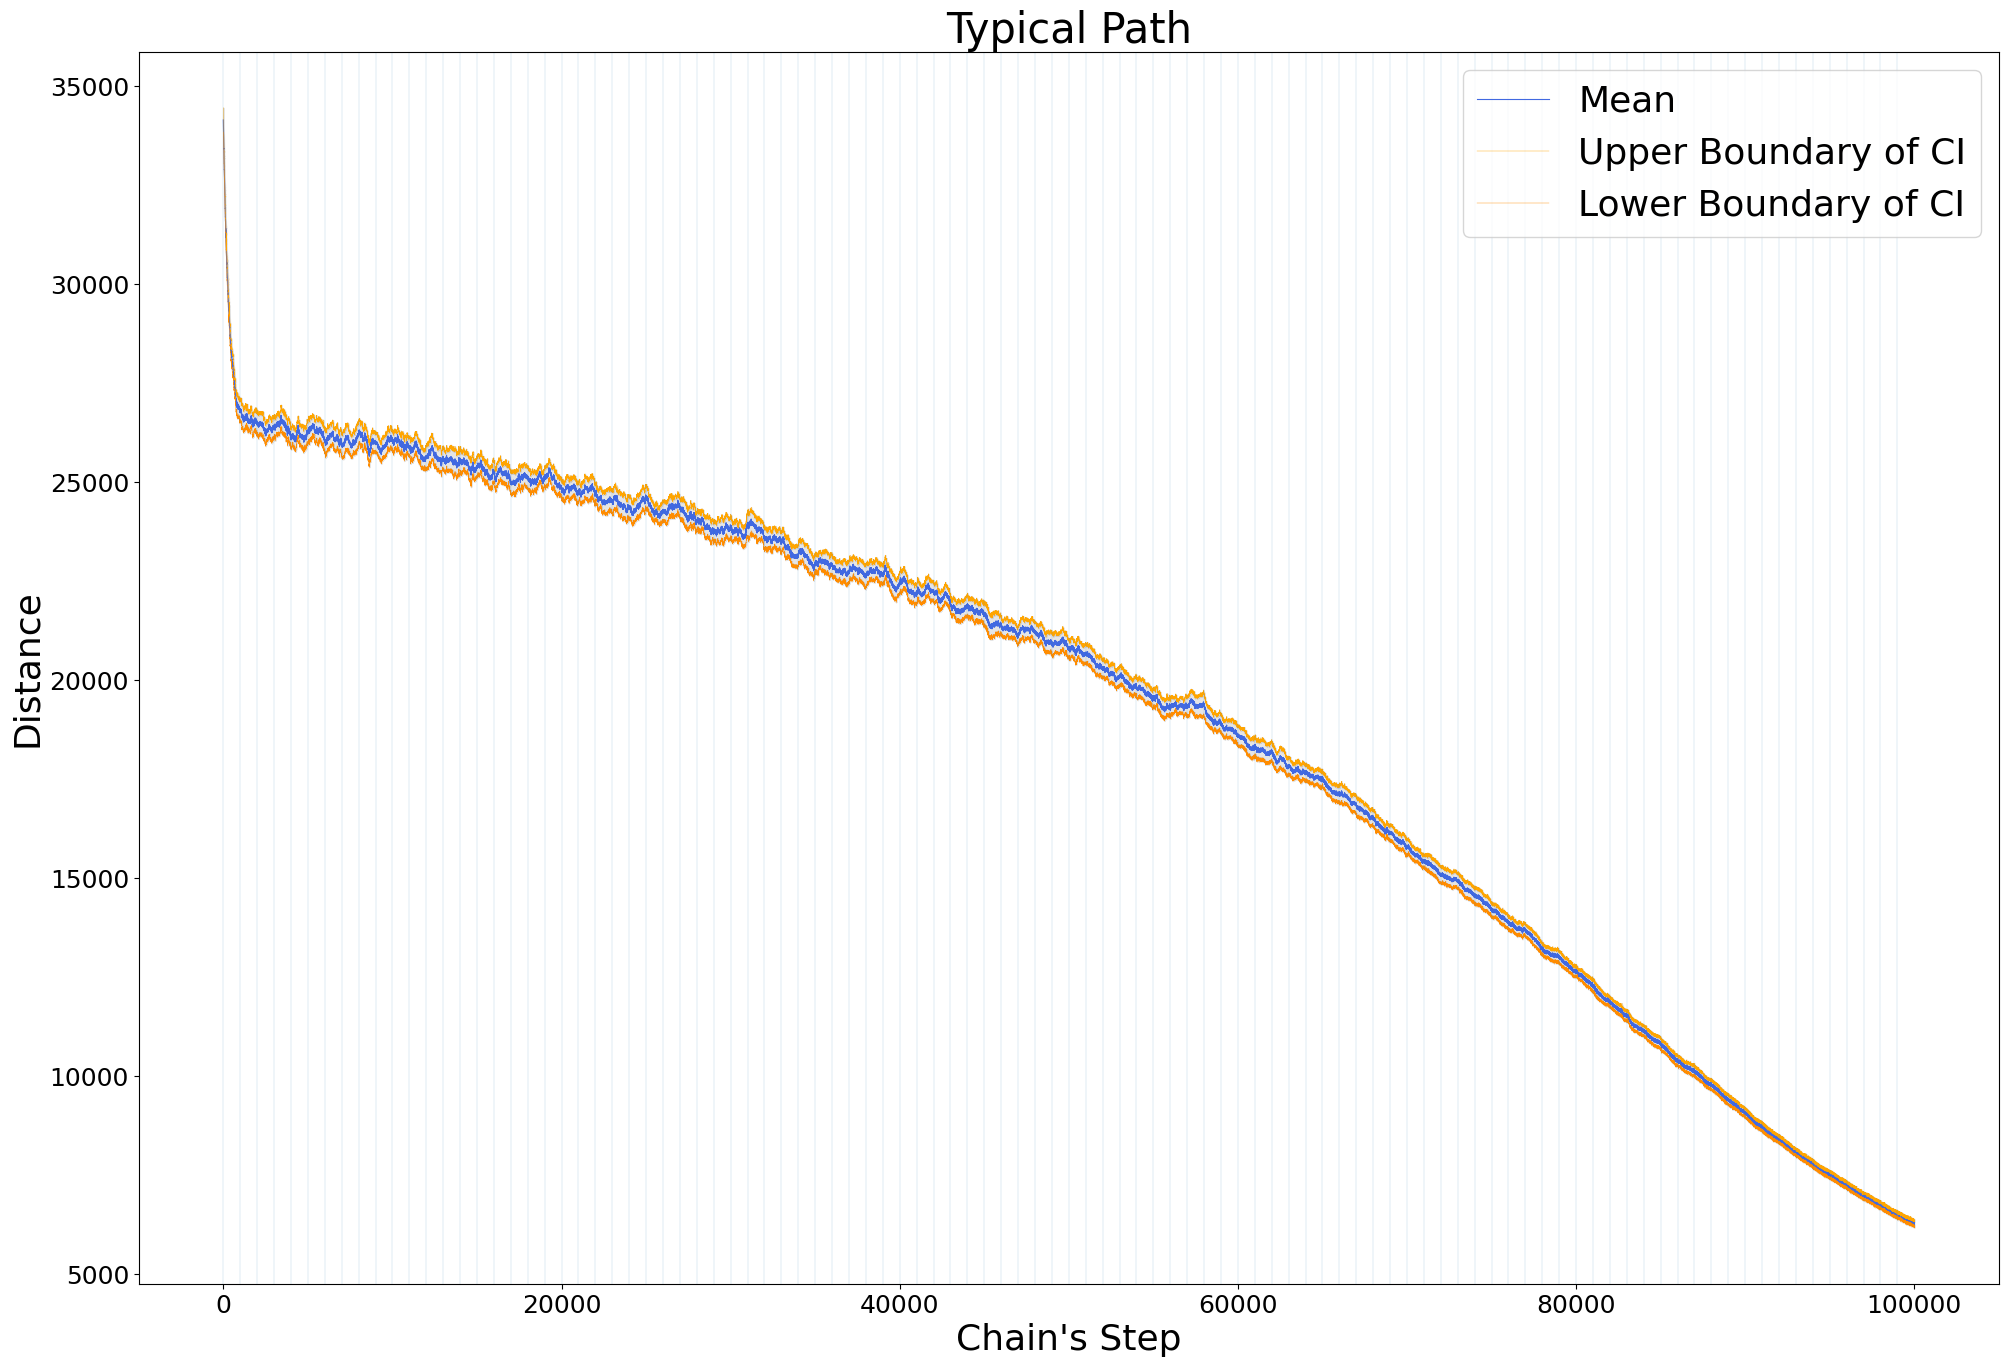

In [10]:
# With Exploration Linear

# Generating Solution
mc_chains = 100
mc_chain_size = 1000

history_chain_solutions = []
history_best_solutions = []
for i in tqdm(range(CI_SAMPLE_SIZE), desc ="Progress of running samples for CI"):
    best_sol, all_sol = annealing_solution_homogenous("k-opt", 2, generate_initial_random_path(cities), mc_chain_size, mc_chains, "lin", True, False)
    history_best_solutions.append(best_sol.eval_distance())
    history_chain_solutions.append(all_sol)

# For visualization we need to Transpose results to find confidence intervals on each step
history_chain_solutions_T = np.array(history_chain_solutions).T
conf_means = []
conf_stds = []
for i in tqdm(range(len(history_chain_solutions_T)), desc ="Generating Visualization of Paths"):
    mean, std = confidence_interval(history_chain_solutions_T[i], 0.95, False)
    conf_means.append(mean)
    conf_stds.append(std)

print("\nBest found paths length: ", confidence_interval(history_best_solutions, 0.95, False))
visualize_conf_interval(conf_means, conf_stds, "Typical Path", "Chain's Step", "Distance", mc_chains, mc_chain_size)

### Without Exploration

Progress of running samples for CI:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\pmchrist\AppData\Local\Temp\ipykernel_22116\1531784266.py:59: RuntimeWarning: overflow encountered in exp
  if np.random.random() < np.exp(-delta_energy / temp_current):
Generating Visualization of Paths: 100%|██████████| 100000/100000 [00:10<00:00, 9195.49it/s]



Best found paths length:  (3321.074063433881, 23.818433177409556)


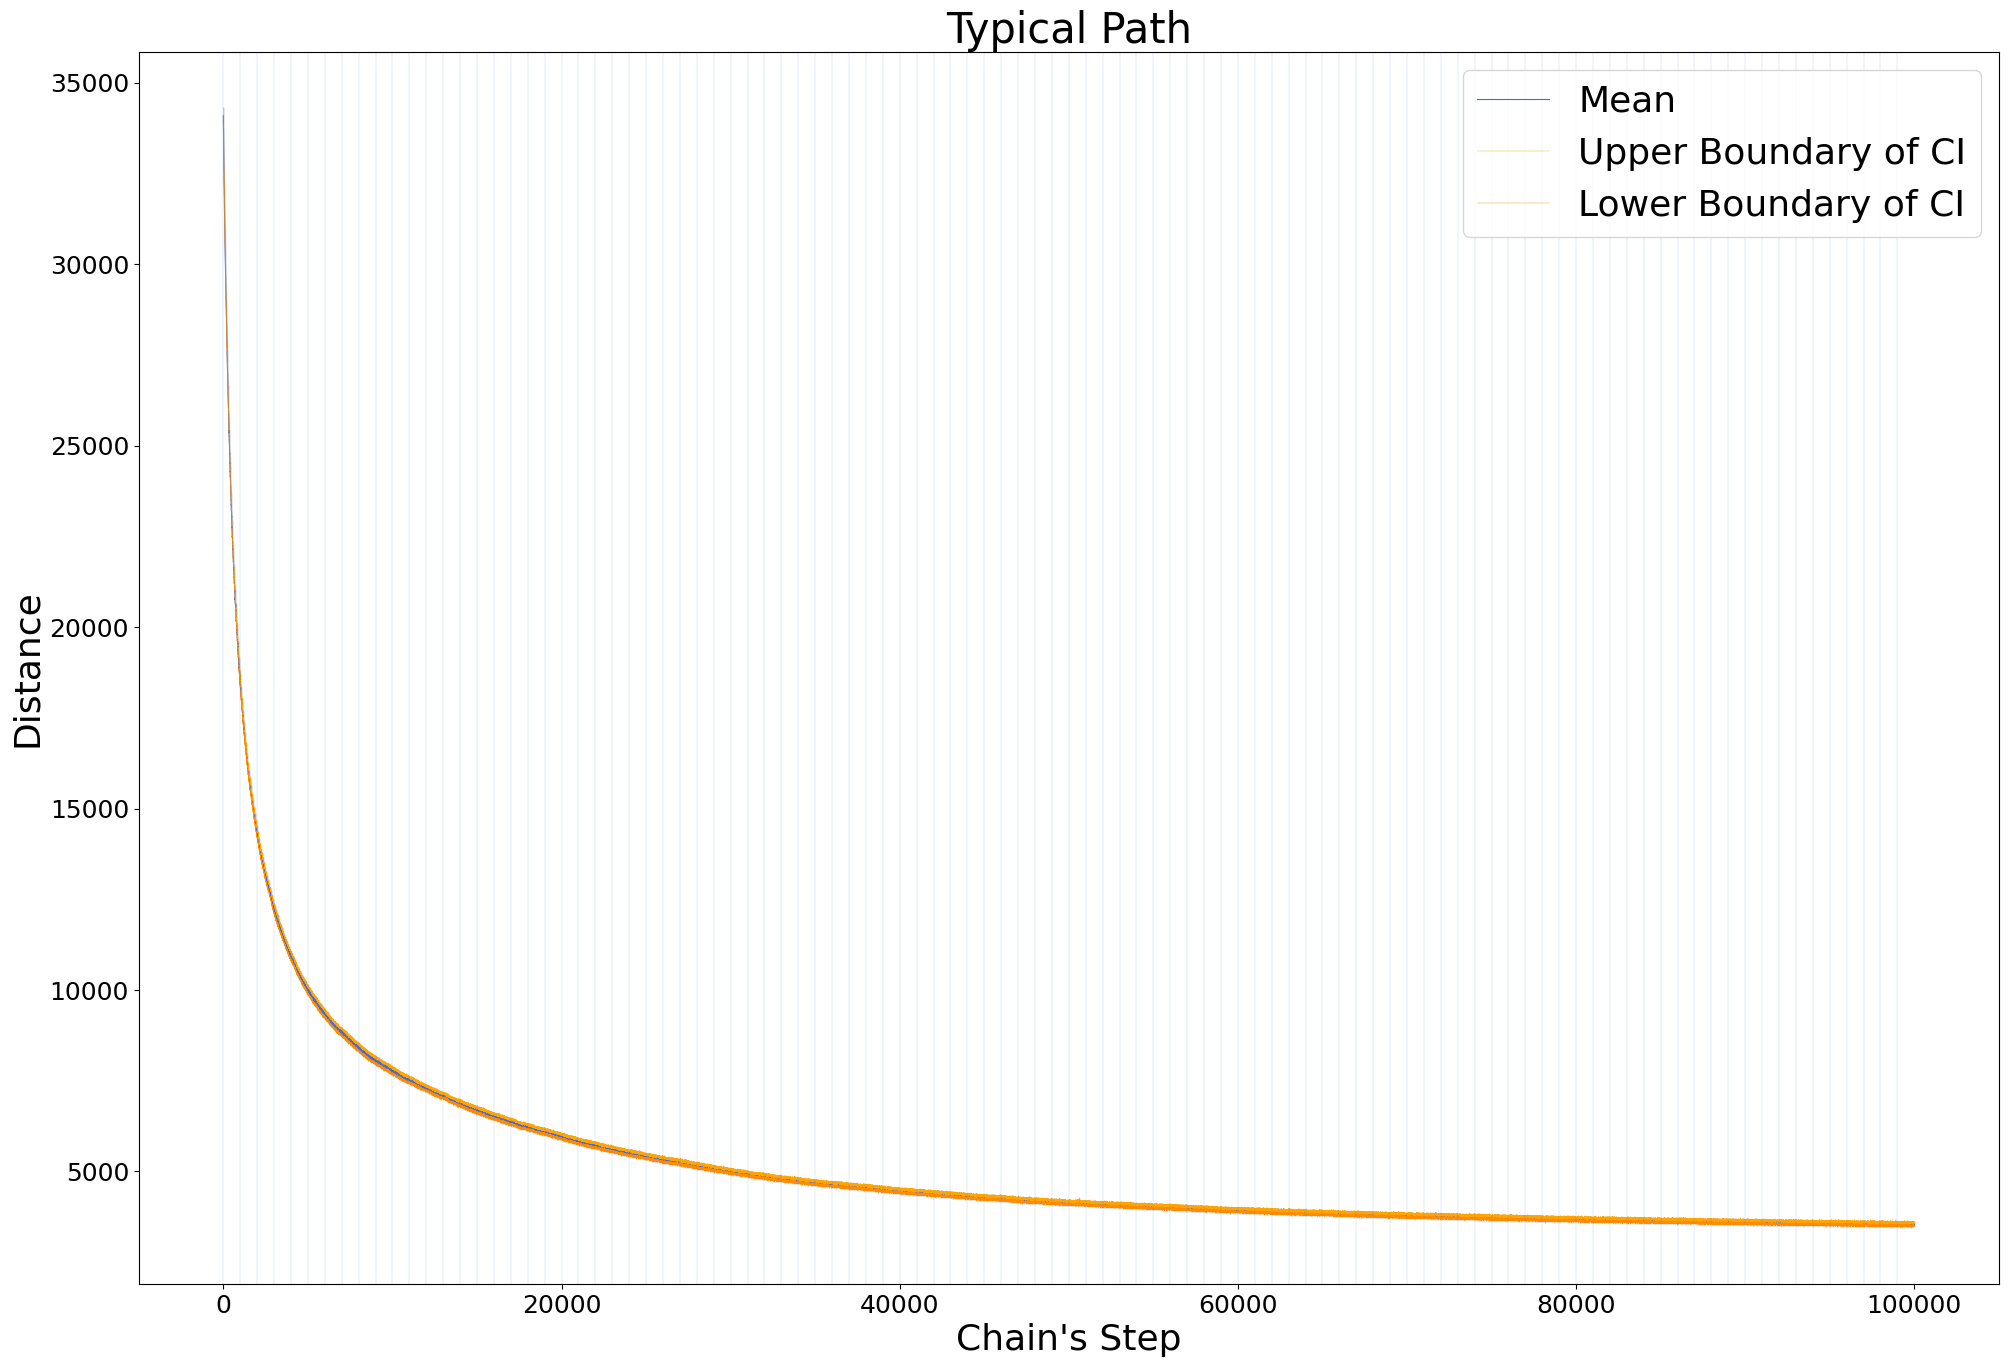

In [11]:
# Without Exploration Exponential

# Generating Solution
mc_chains = 100
mc_chain_size = 1000

history_chain_solutions = []
history_best_solutions = []
for i in tqdm(range(CI_SAMPLE_SIZE), desc ="Progress of running samples for CI"):
    best_sol, all_sol = annealing_solution_homogenous("k-opt", 2, generate_initial_random_path(cities), mc_chain_size, mc_chains, "exp", False, False)
    history_best_solutions.append(best_sol.eval_distance())
    history_chain_solutions.append(all_sol)

# For visualization we need to Transpose results to find confidence intervals on each step
history_chain_solutions_T = np.array(history_chain_solutions).T
conf_means = []
conf_stds = []
for i in tqdm(range(len(history_chain_solutions_T)), desc ="Generating Visualization of Paths"):
    mean, std = confidence_interval(history_chain_solutions_T[i], 0.95, False)
    conf_means.append(mean)
    conf_stds.append(std)

print("\nBest found paths length: ", confidence_interval(history_best_solutions, 0.95, False))
visualize_conf_interval(conf_means, conf_stds, "Typical Path", "Chain's Step", "Distance", mc_chains, mc_chain_size)

Progress of running samples for CI:   0%|          | 0/50 [00:00<?, ?it/s]

Generating Visualization of Paths: 100%|██████████| 100000/100000 [00:11<00:00, 9072.82it/s]



Best found paths length:  (3515.19567063973, 26.458082360748453)


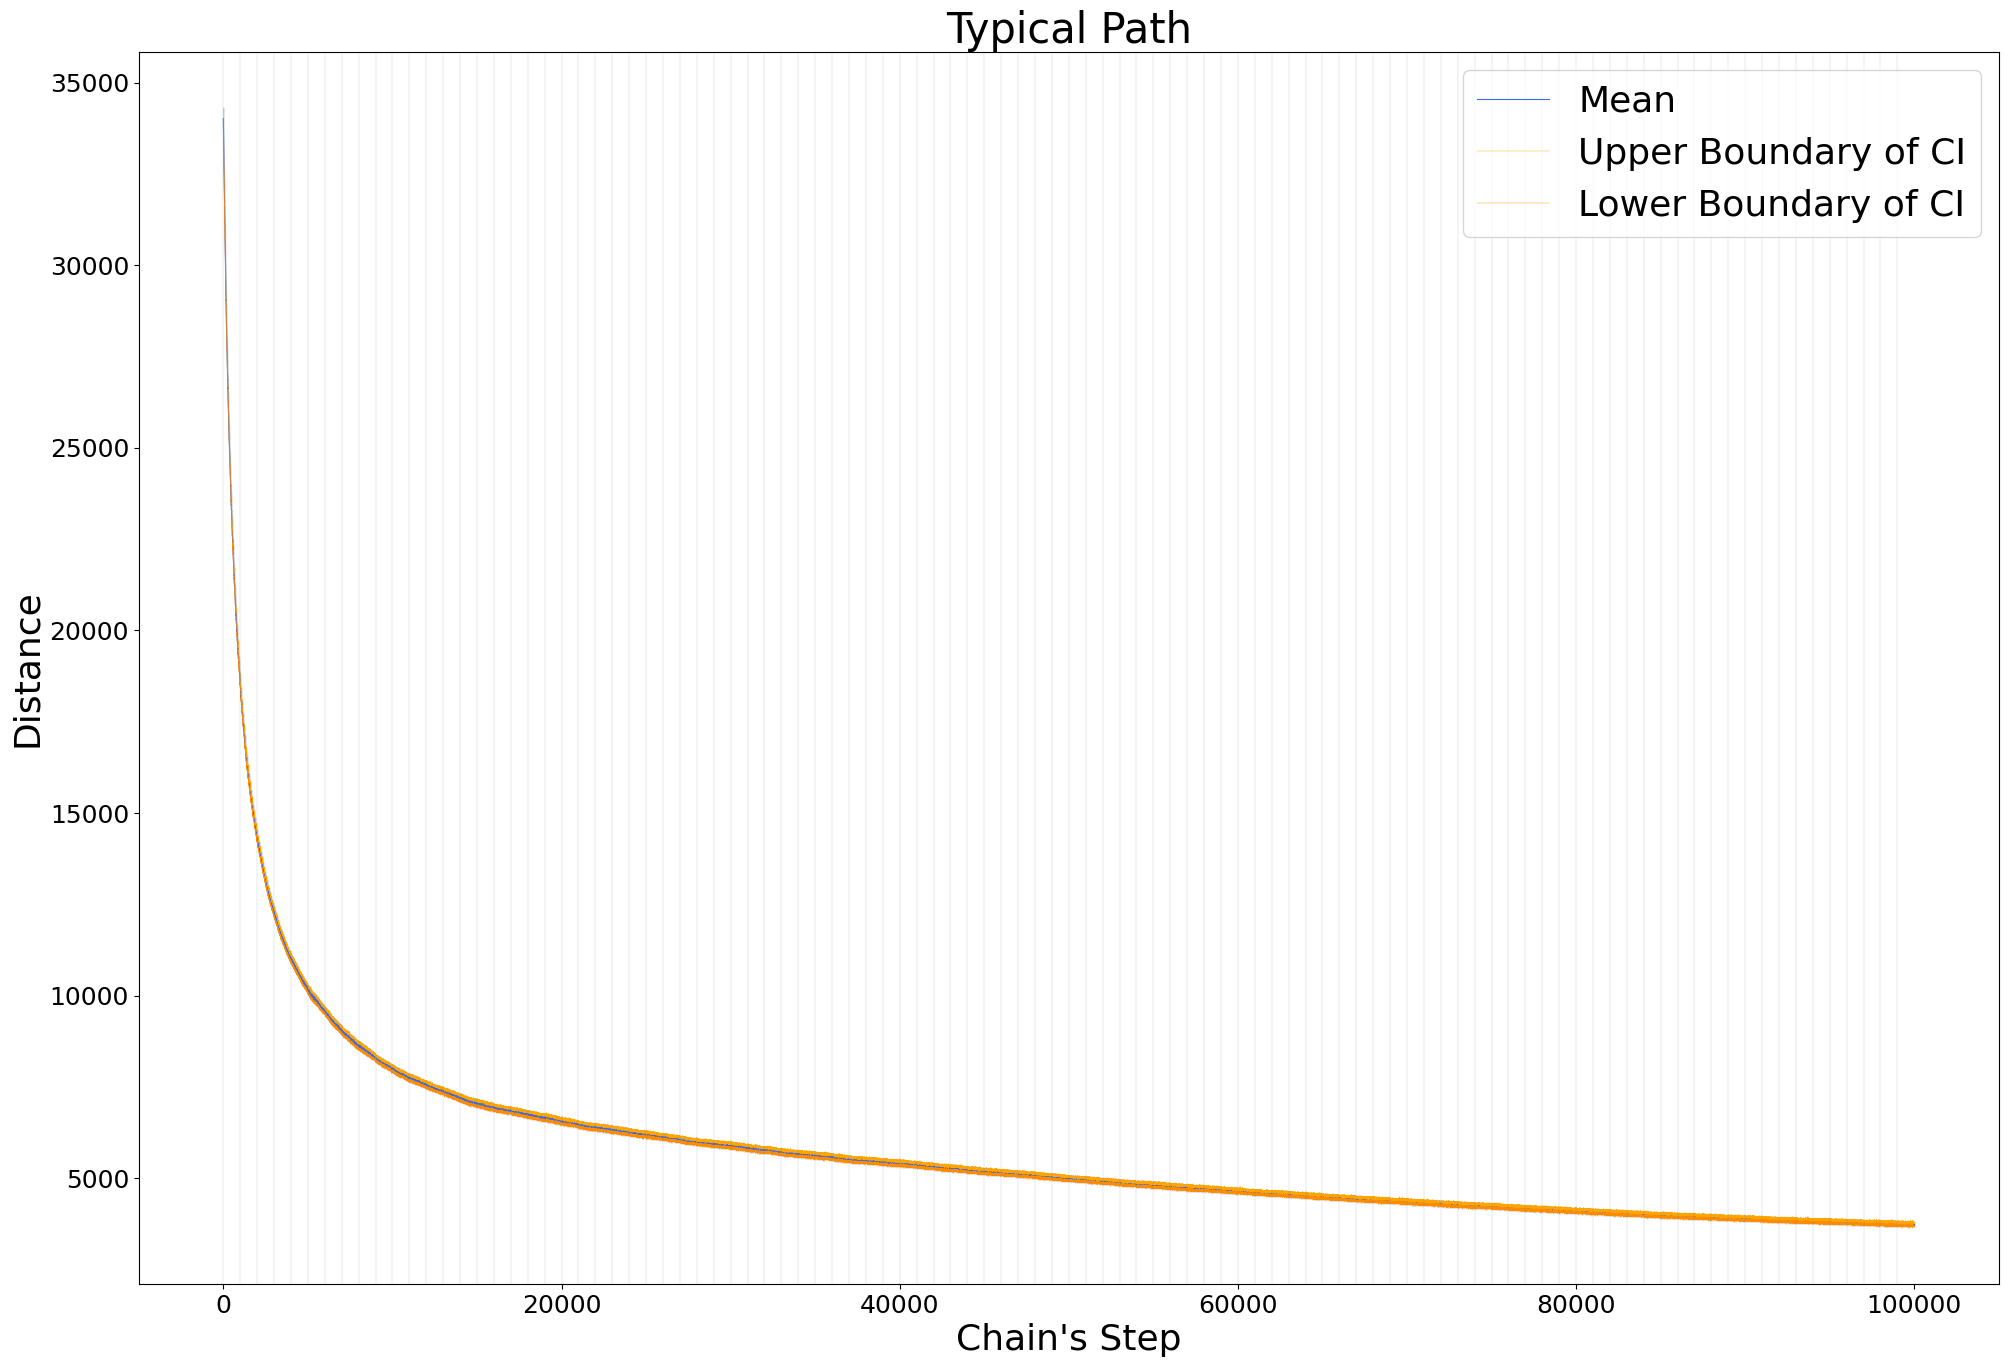

In [12]:
# Without Exploration Linear

# Generating Solution
mc_chains = 100
mc_chain_size = 1000

history_chain_solutions = []
history_best_solutions = []
for i in tqdm(range(CI_SAMPLE_SIZE), desc ="Progress of running samples for CI"):
    best_sol, all_sol = annealing_solution_homogenous("k-opt", 2, generate_initial_random_path(cities), mc_chain_size, mc_chains, "lin", False, False)
    history_best_solutions.append(best_sol.eval_distance())
    history_chain_solutions.append(all_sol)

# For visualization we need to Transpose results to find confidence intervals on each step
history_chain_solutions_T = np.array(history_chain_solutions).T
conf_means = []
conf_stds = []
for i in tqdm(range(len(history_chain_solutions_T)), desc ="Generating Visualization of Paths"):
    mean, std = confidence_interval(history_chain_solutions_T[i], 0.95, False)
    conf_means.append(mean)
    conf_stds.append(std)

print("\nBest found paths length: ", confidence_interval(history_best_solutions, 0.95, False))
visualize_conf_interval(conf_means, conf_stds, "Typical Path", "Chain's Step", "Distance", mc_chains, mc_chain_size)

## SA test: Cooling Schedule

Progress of running samples for CI:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\pmchrist\AppData\Local\Temp\ipykernel_22116\1531784266.py:59: RuntimeWarning: overflow encountered in exp
  if np.random.random() < np.exp(-delta_energy / temp_current):
Generating Visualization of Paths: 100%|██████████| 100000/100000 [00:11<00:00, 9048.22it/s]



Best found paths length:  (3505.4305740685395, 27.282618459291903)


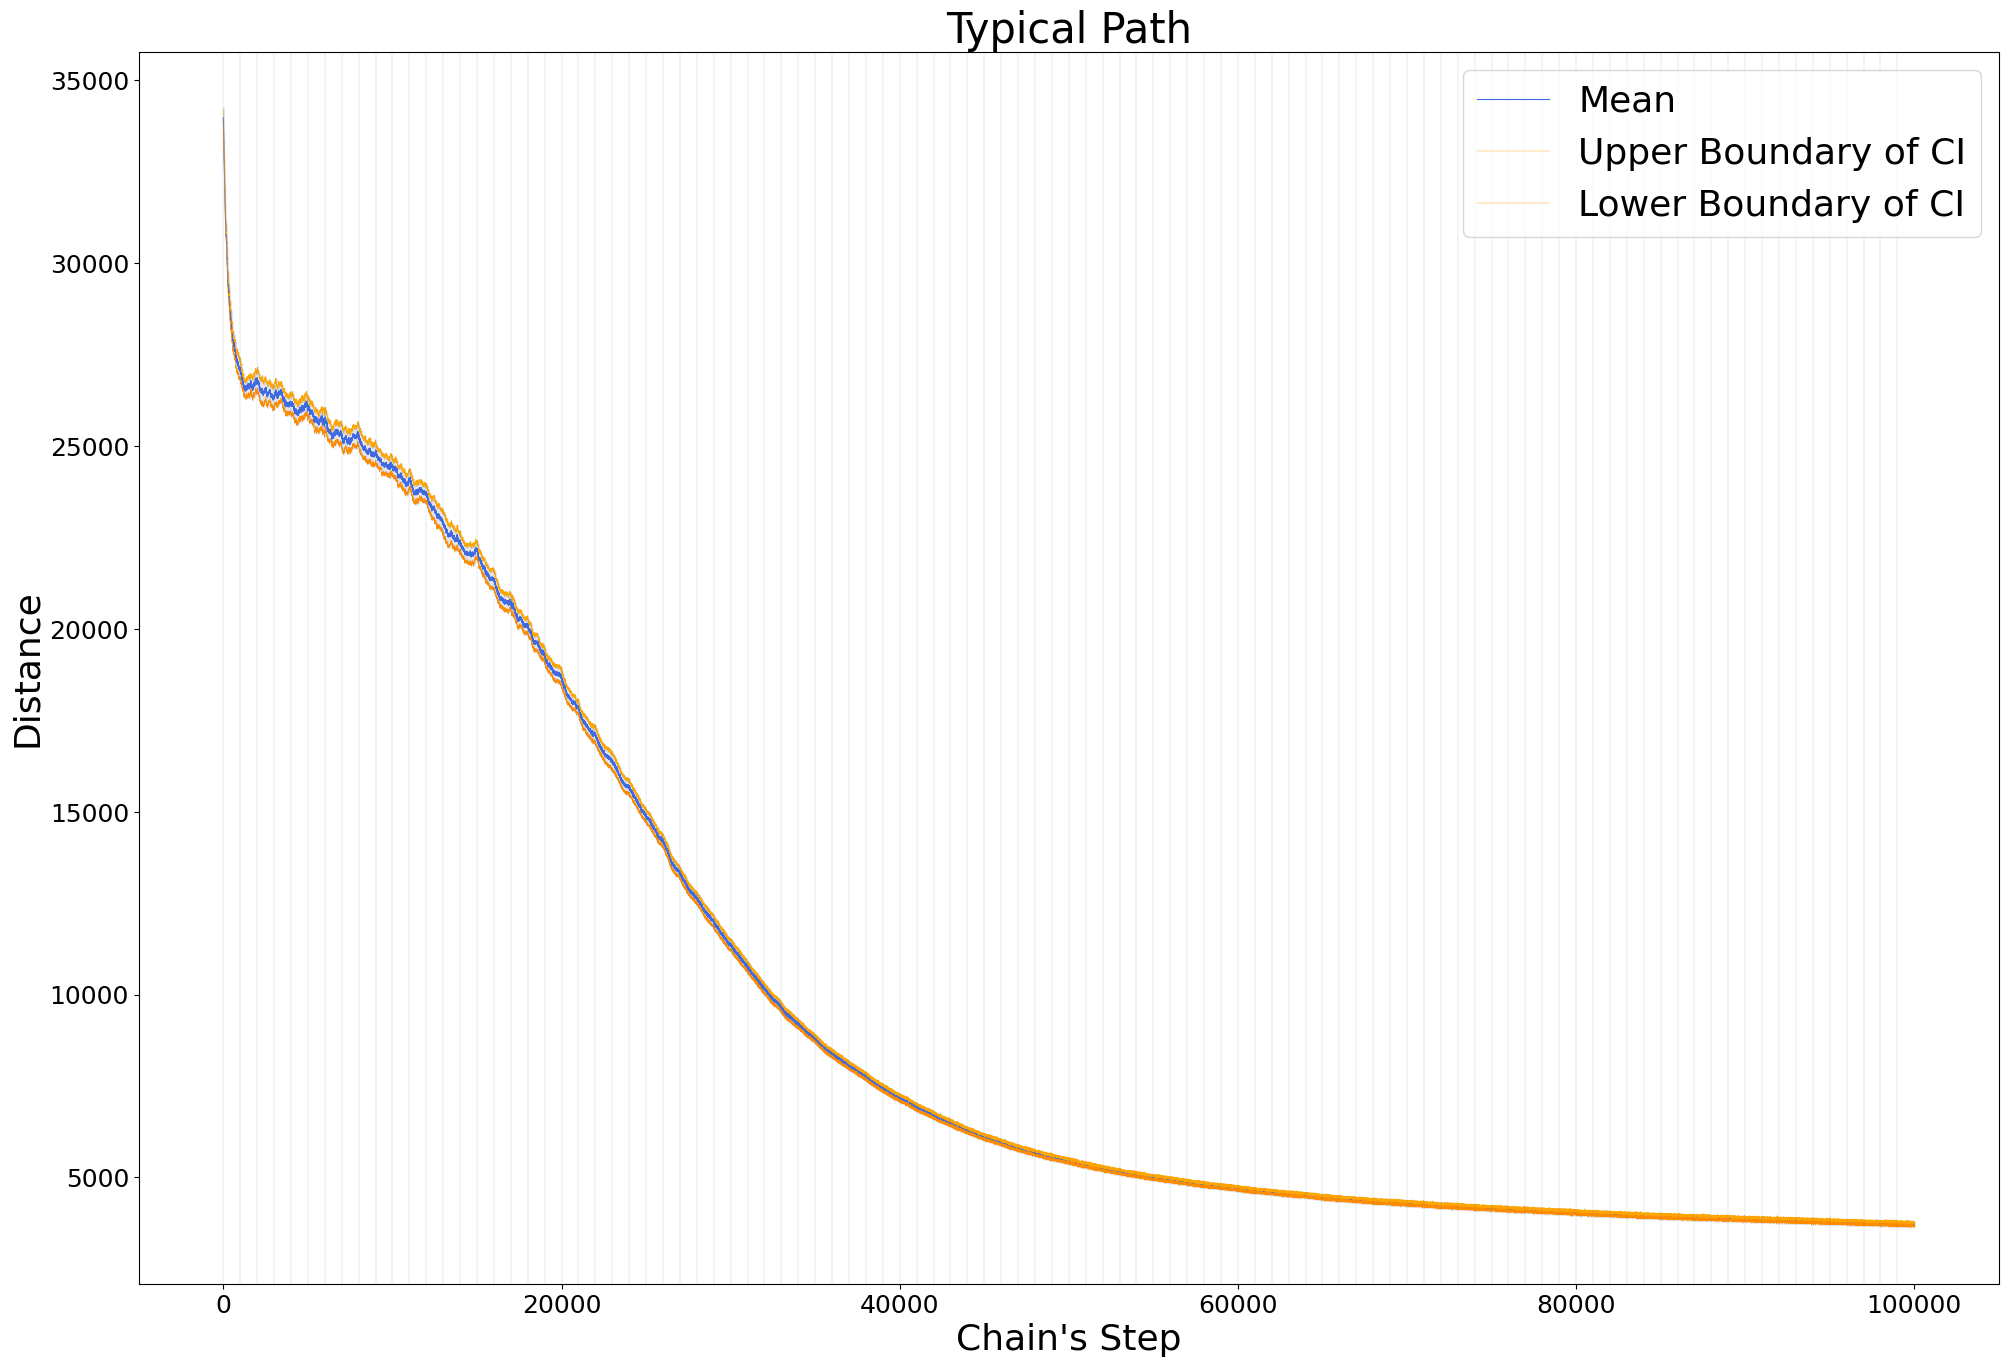

In [13]:
# Exponential

# Generating Solution
mc_chains = 100
mc_chain_size = 1000

history_chain_solutions = []
history_best_solutions = []
for i in tqdm(range(CI_SAMPLE_SIZE), desc ="Progress of running samples for CI"):
    best_sol, all_sol = annealing_solution_homogenous("k-opt", 2, generate_initial_random_path(cities), mc_chain_size, mc_chains, "exp", True, False)
    history_best_solutions.append(best_sol.eval_distance())
    history_chain_solutions.append(all_sol)

# For visualization we need to Transpose results to find confidence intervals on each step
history_chain_solutions_T = np.array(history_chain_solutions).T
conf_means = []
conf_stds = []
for i in tqdm(range(len(history_chain_solutions_T)), desc ="Generating Visualization of Paths"):
    mean, std = confidence_interval(history_chain_solutions_T[i], 0.95, False)
    conf_means.append(mean)
    conf_stds.append(std)

print("\nBest found paths length: ", confidence_interval(history_best_solutions, 0.95, False))
visualize_conf_interval(conf_means, conf_stds, "Typical Path", "Chain's Step", "Distance", mc_chains, mc_chain_size)

Progress of running samples for CI:   2%|▏         | 1/50 [00:52<42:29, 52.04s/it]C:\Users\pmchrist\AppData\Local\Temp\ipykernel_22116\1531784266.py:59: RuntimeWarning: overflow encountered in exp
  if np.random.random() < np.exp(-delta_energy / temp_current):
Generating Visualization of Paths: 100%|██████████| 100000/100000 [00:11<00:00, 9016.78it/s]



Best found paths length:  (4314.6484268635195, 32.77636531564415)


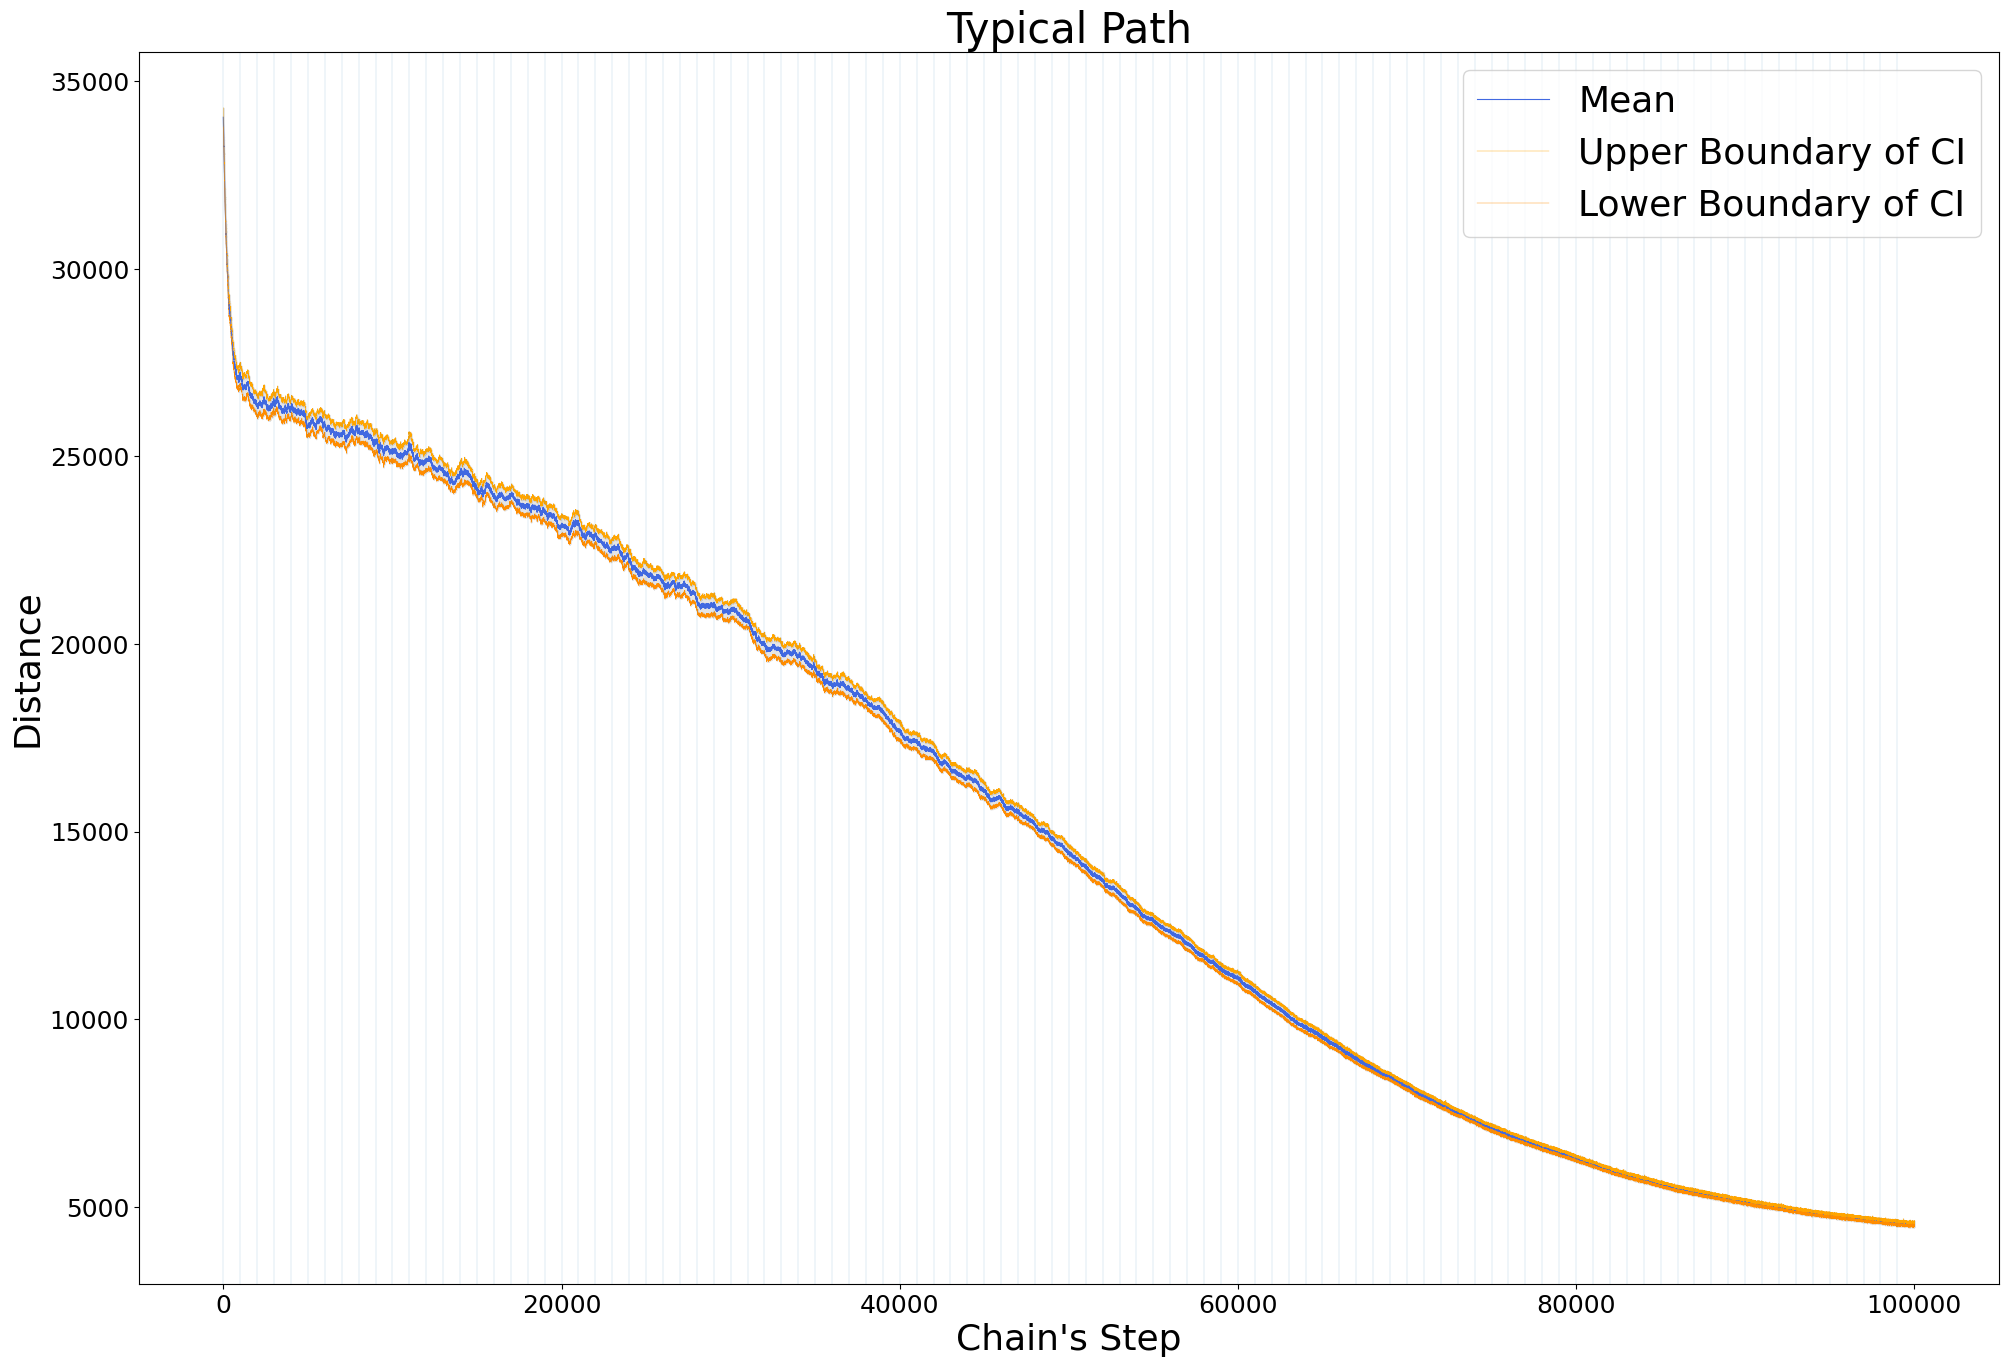

In [14]:
# Quadratic

# Generating Solution
mc_chains = 100
mc_chain_size = 1000

history_chain_solutions = []
history_best_solutions = []
for i in tqdm(range(CI_SAMPLE_SIZE), desc ="Progress of running samples for CI"):
    best_sol, all_sol = annealing_solution_homogenous("k-opt", 2, generate_initial_random_path(cities), mc_chain_size, mc_chains, "quad", True, False)
    history_best_solutions.append(best_sol.eval_distance())
    history_chain_solutions.append(all_sol)

# For visualization we need to Transpose results to find confidence intervals on each step
history_chain_solutions_T = np.array(history_chain_solutions).T
conf_means = []
conf_stds = []
for i in tqdm(range(len(history_chain_solutions_T)), desc ="Generating Visualization of Paths"):
    mean, std = confidence_interval(history_chain_solutions_T[i], 0.95, False)
    conf_means.append(mean)
    conf_stds.append(std)

print("\nBest found paths length: ", confidence_interval(history_best_solutions, 0.95, False))
visualize_conf_interval(conf_means, conf_stds, "Typical Path", "Chain's Step", "Distance", mc_chains, mc_chain_size)

Progress of running samples for CI:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\pmchrist\AppData\Local\Temp\ipykernel_22116\1531784266.py:59: RuntimeWarning: overflow encountered in exp
  if np.random.random() < np.exp(-delta_energy / temp_current):
Generating Visualization of Paths: 100%|██████████| 100000/100000 [00:11<00:00, 9082.09it/s]



Best found paths length:  (4892.995719757784, 38.42792119483808)


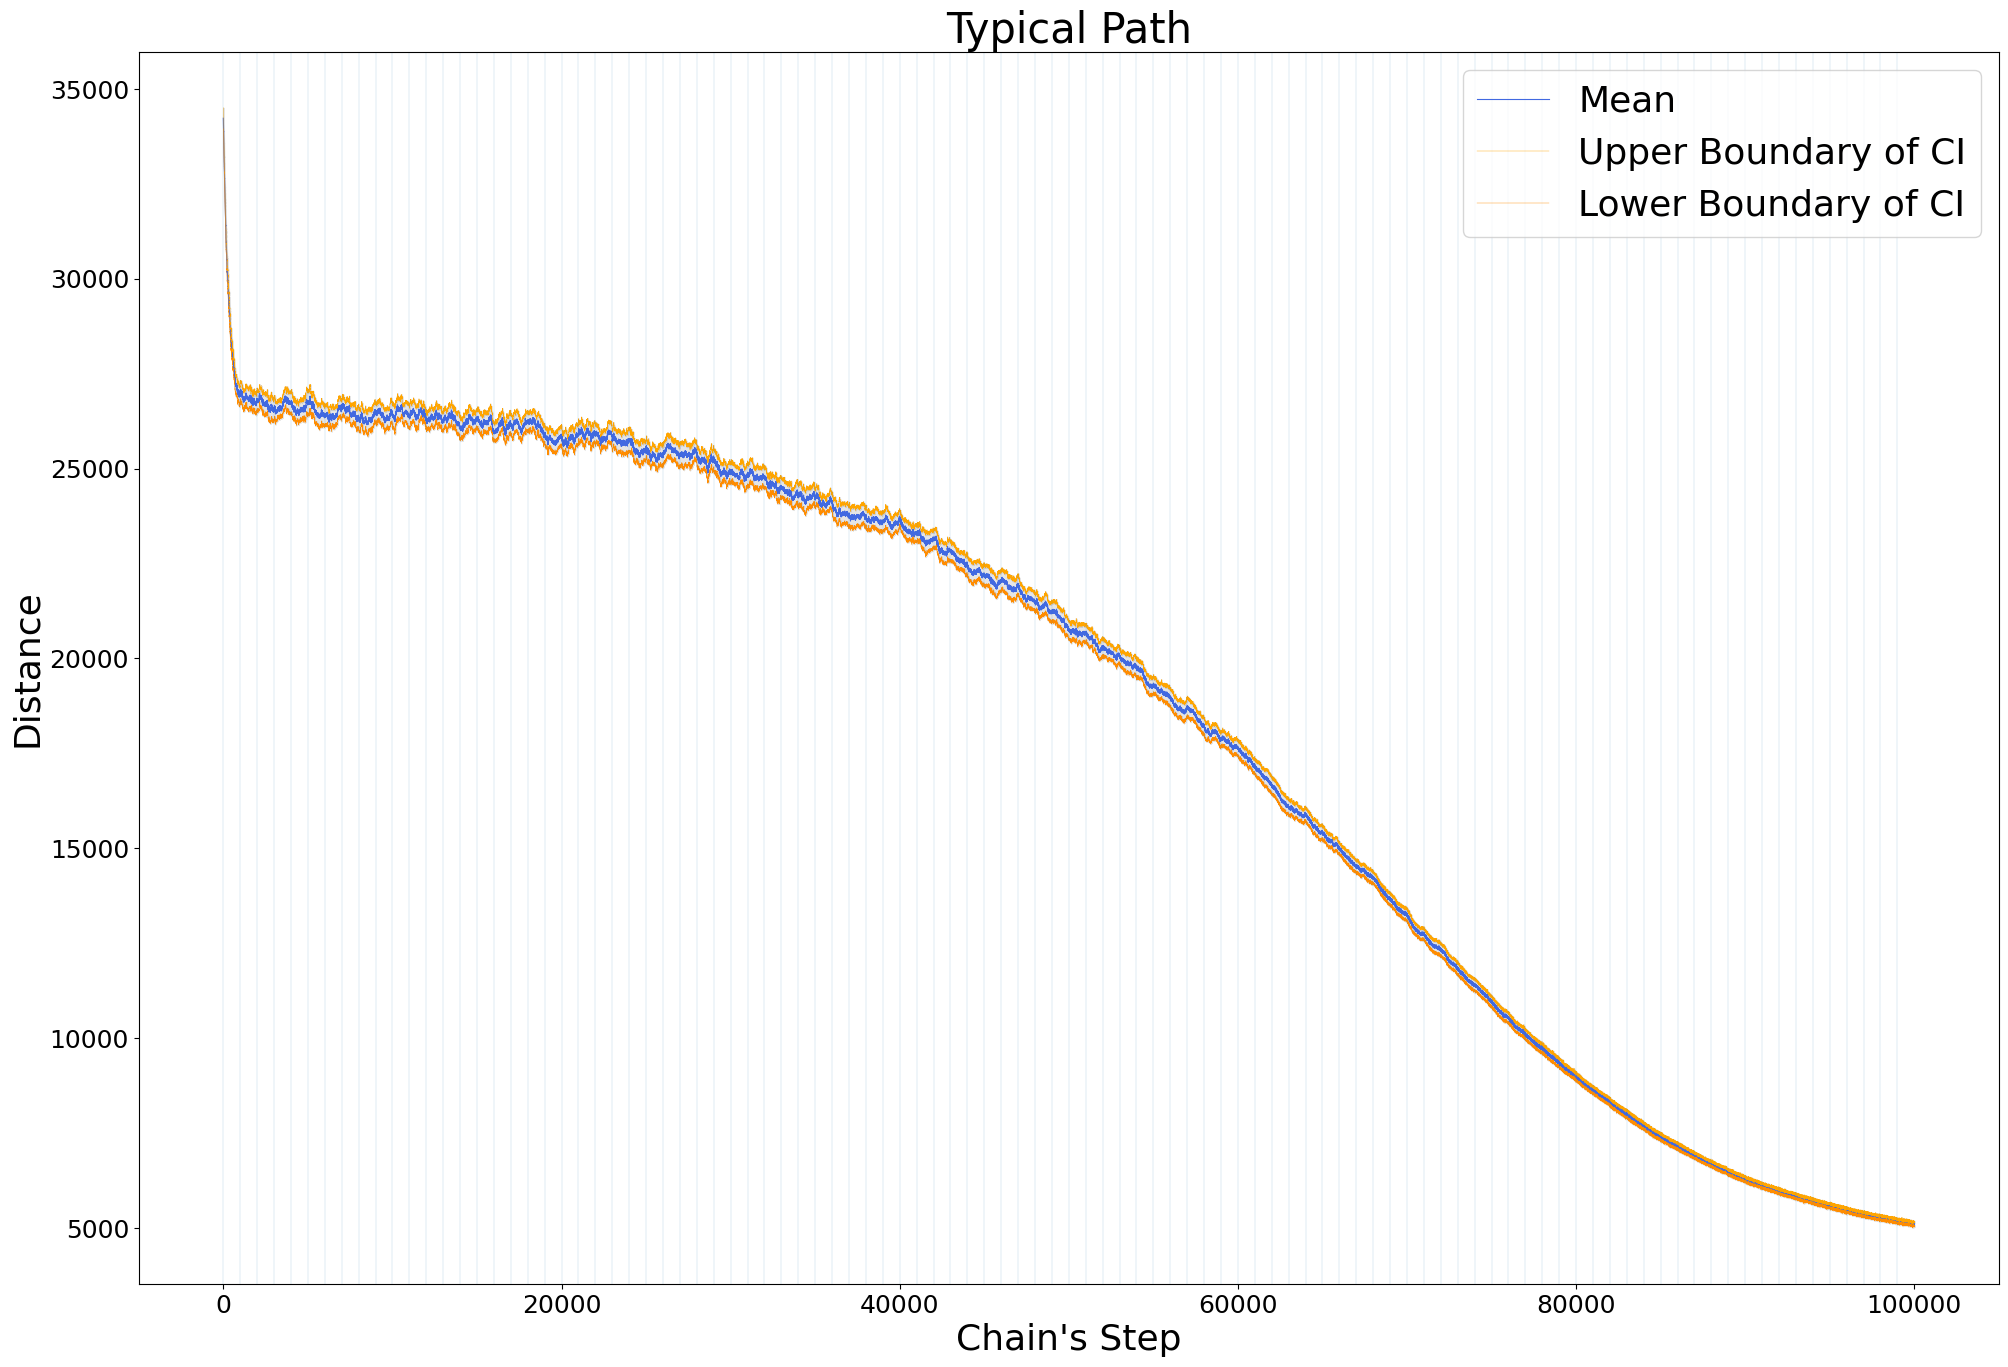

In [15]:
# Cosinus

# Generating Solution
mc_chains = 100
mc_chain_size = 1000

history_chain_solutions = []
history_best_solutions = []
for i in tqdm(range(CI_SAMPLE_SIZE), desc ="Progress of running samples for CI"):
    best_sol, all_sol = annealing_solution_homogenous("k-opt", 2, generate_initial_random_path(cities), mc_chain_size, mc_chains, "cos", True, False)
    history_best_solutions.append(best_sol.eval_distance())
    history_chain_solutions.append(all_sol)

# For visualization we need to Transpose results to find confidence intervals on each step
history_chain_solutions_T = np.array(history_chain_solutions).T
conf_means = []
conf_stds = []
for i in tqdm(range(len(history_chain_solutions_T)), desc ="Generating Visualization of Paths"):
    mean, std = confidence_interval(history_chain_solutions_T[i], 0.95, False)
    conf_means.append(mean)
    conf_stds.append(std)

print("\nBest found paths length: ", confidence_interval(history_best_solutions, 0.95, False))
visualize_conf_interval(conf_means, conf_stds, "Typical Path", "Chain's Step", "Distance", mc_chains, mc_chain_size)

Generating Visualization of Paths: 100%|██████████| 100000/100000 [00:10<00:00, 9309.81it/s]



Best found paths length:  (6122.248802934981, 62.905561276202604)


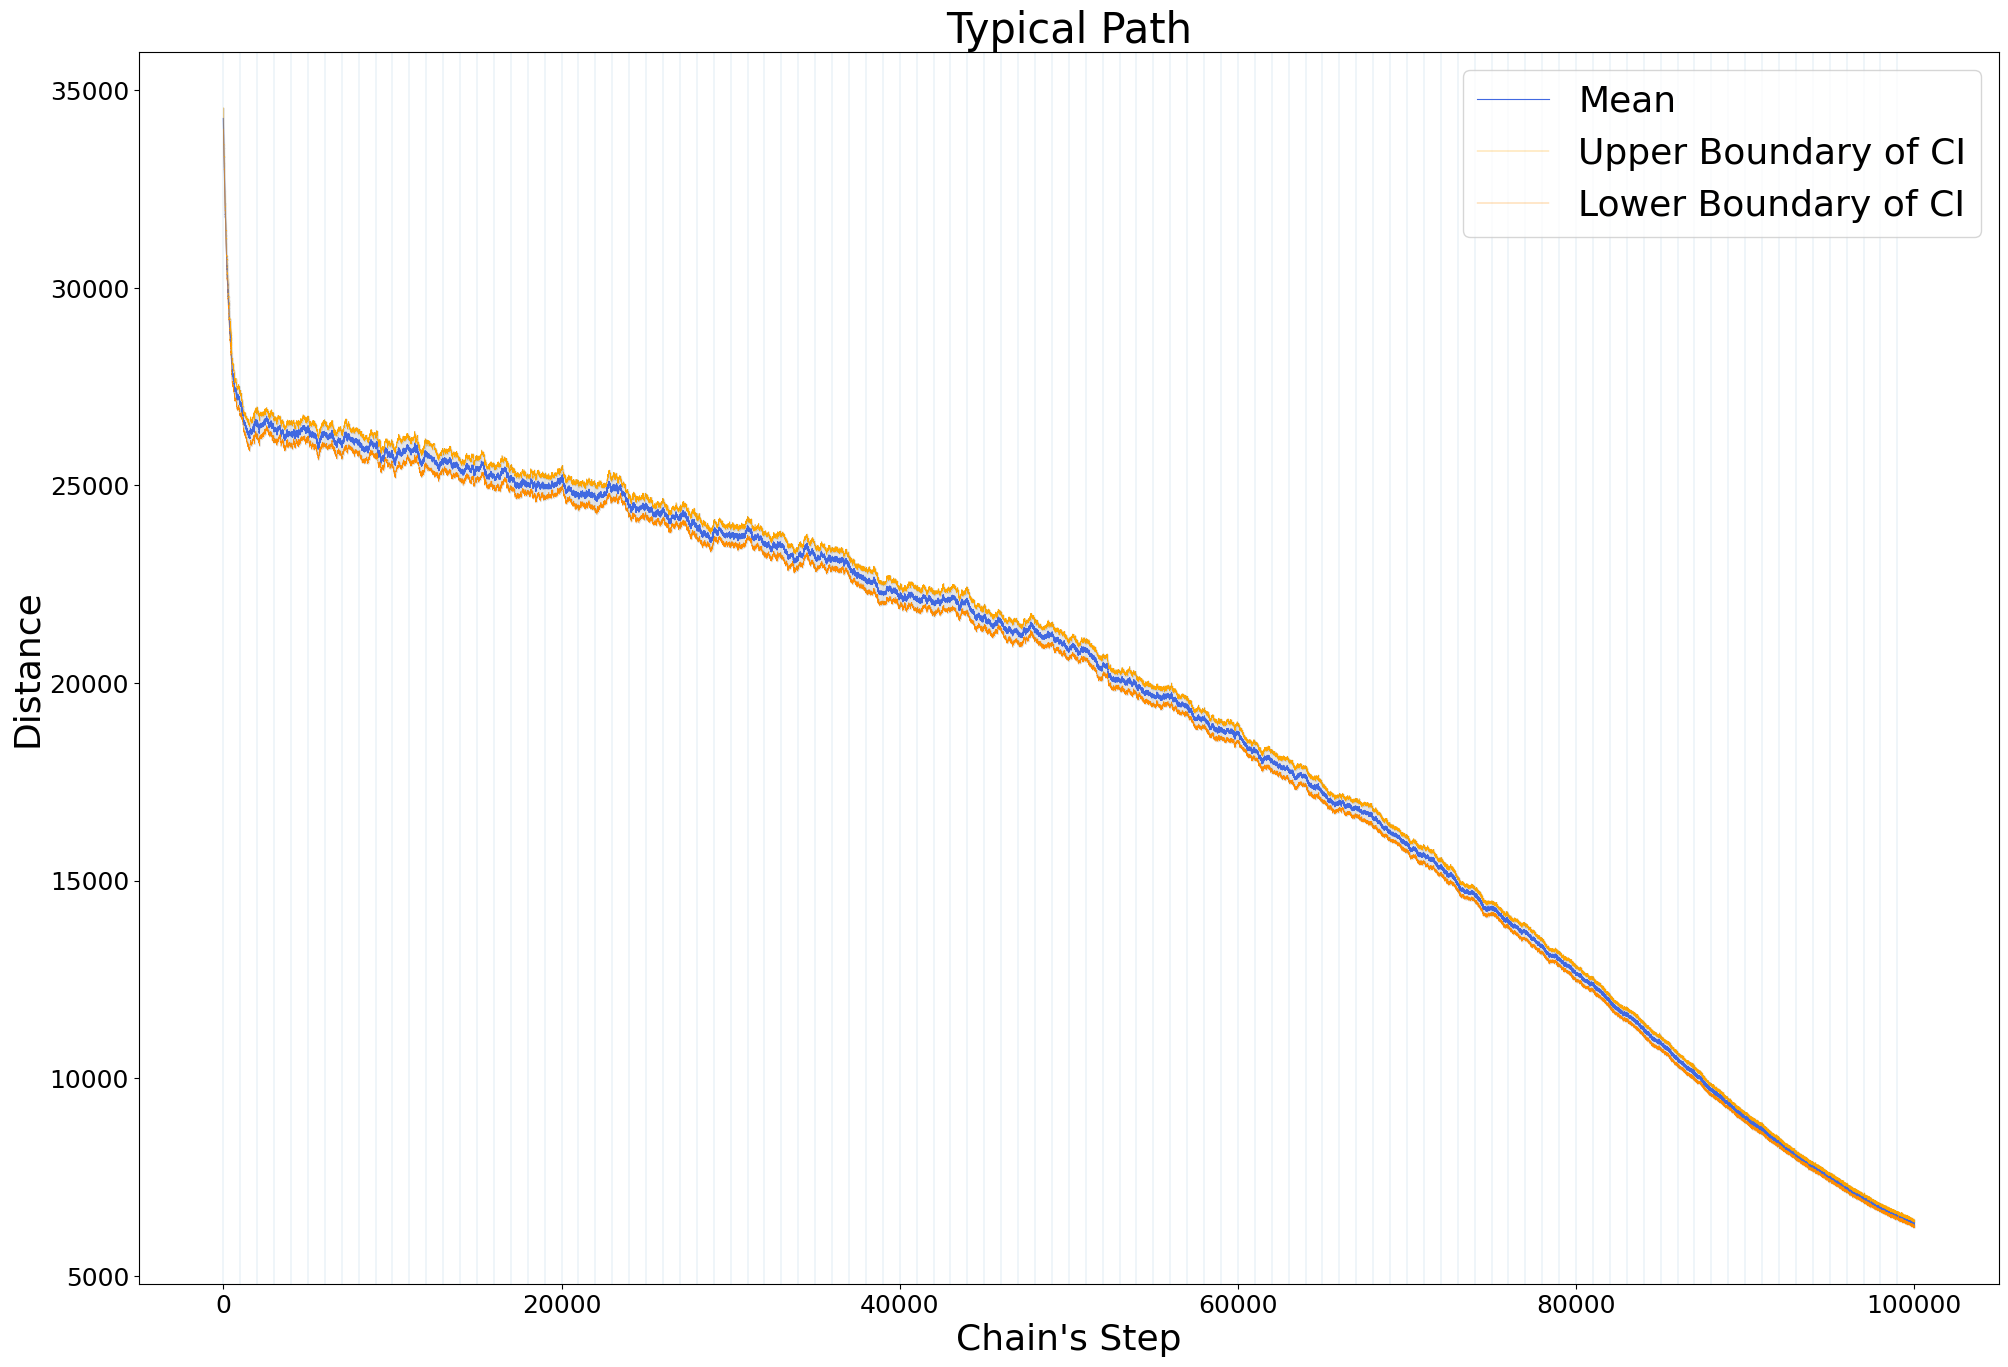

In [16]:
# Linear

# Generating Solution
mc_chains = 100
mc_chain_size = 1000

history_chain_solutions = []
history_best_solutions = []
for i in tqdm(range(CI_SAMPLE_SIZE), desc ="Progress of running samples for CI"):
    best_sol, all_sol = annealing_solution_homogenous("k-opt", 2, generate_initial_random_path(cities), mc_chain_size, mc_chains, "lin", True, False)
    history_best_solutions.append(best_sol.eval_distance())
    history_chain_solutions.append(all_sol)

# For visualization we need to Transpose results to find confidence intervals on each step
history_chain_solutions_T = np.array(history_chain_solutions).T
conf_means = []
conf_stds = []
for i in tqdm(range(len(history_chain_solutions_T)), desc ="Generating Visualization of Paths"):
    mean, std = confidence_interval(history_chain_solutions_T[i], 0.95, False)
    conf_means.append(mean)
    conf_stds.append(std)

print("\nBest found paths length: ", confidence_interval(history_best_solutions, 0.95, False))
visualize_conf_interval(conf_means, conf_stds, "Typical Path", "Chain's Step", "Distance", mc_chains, mc_chain_size)

## SA test: Comparing MC Inner Chain Size

Progress of running samples for CI:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\pmchrist\AppData\Local\Temp\ipykernel_22116\1531784266.py:59: RuntimeWarning: overflow encountered in exp
  if np.random.random() < np.exp(-delta_energy / temp_current):
Generating Visualization of Paths: 100%|██████████| 10000/10000 [00:01<00:00, 9075.13it/s]



Best found paths length:  (9019.591454545733, 77.41554277486561)


Progress of running samples for CI:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\pmchrist\AppData\Local\Temp\ipykernel_22116\1531784266.py:59: RuntimeWarning: overflow encountered in exp
  if np.random.random() < np.exp(-delta_energy / temp_current):
Generating Visualization of Paths: 100%|██████████| 100000/100000 [00:10<00:00, 9163.88it/s]



Best found paths length:  (4335.746726871343, 37.96485049852521)


Progress of running samples for CI:  12%|█▏        | 6/50 [52:09<6:22:28, 521.55s/it]C:\Users\pmchrist\AppData\Local\Temp\ipykernel_22116\1531784266.py:59: RuntimeWarning: overflow encountered in exp
  if np.random.random() < np.exp(-delta_energy / temp_current):
Generating Visualization of Paths: 100%|██████████| 1000000/1000000 [01:47<00:00, 9260.36it/s]



Best found paths length:  (2988.7868387804715, 26.31593412298207)


Generating Visualization of Paths: 100%|██████████| 10000000/10000000 [17:13<00:00, 9671.87it/s]



Best found paths length:  (2797.2065010665724, 18.16338654193944)


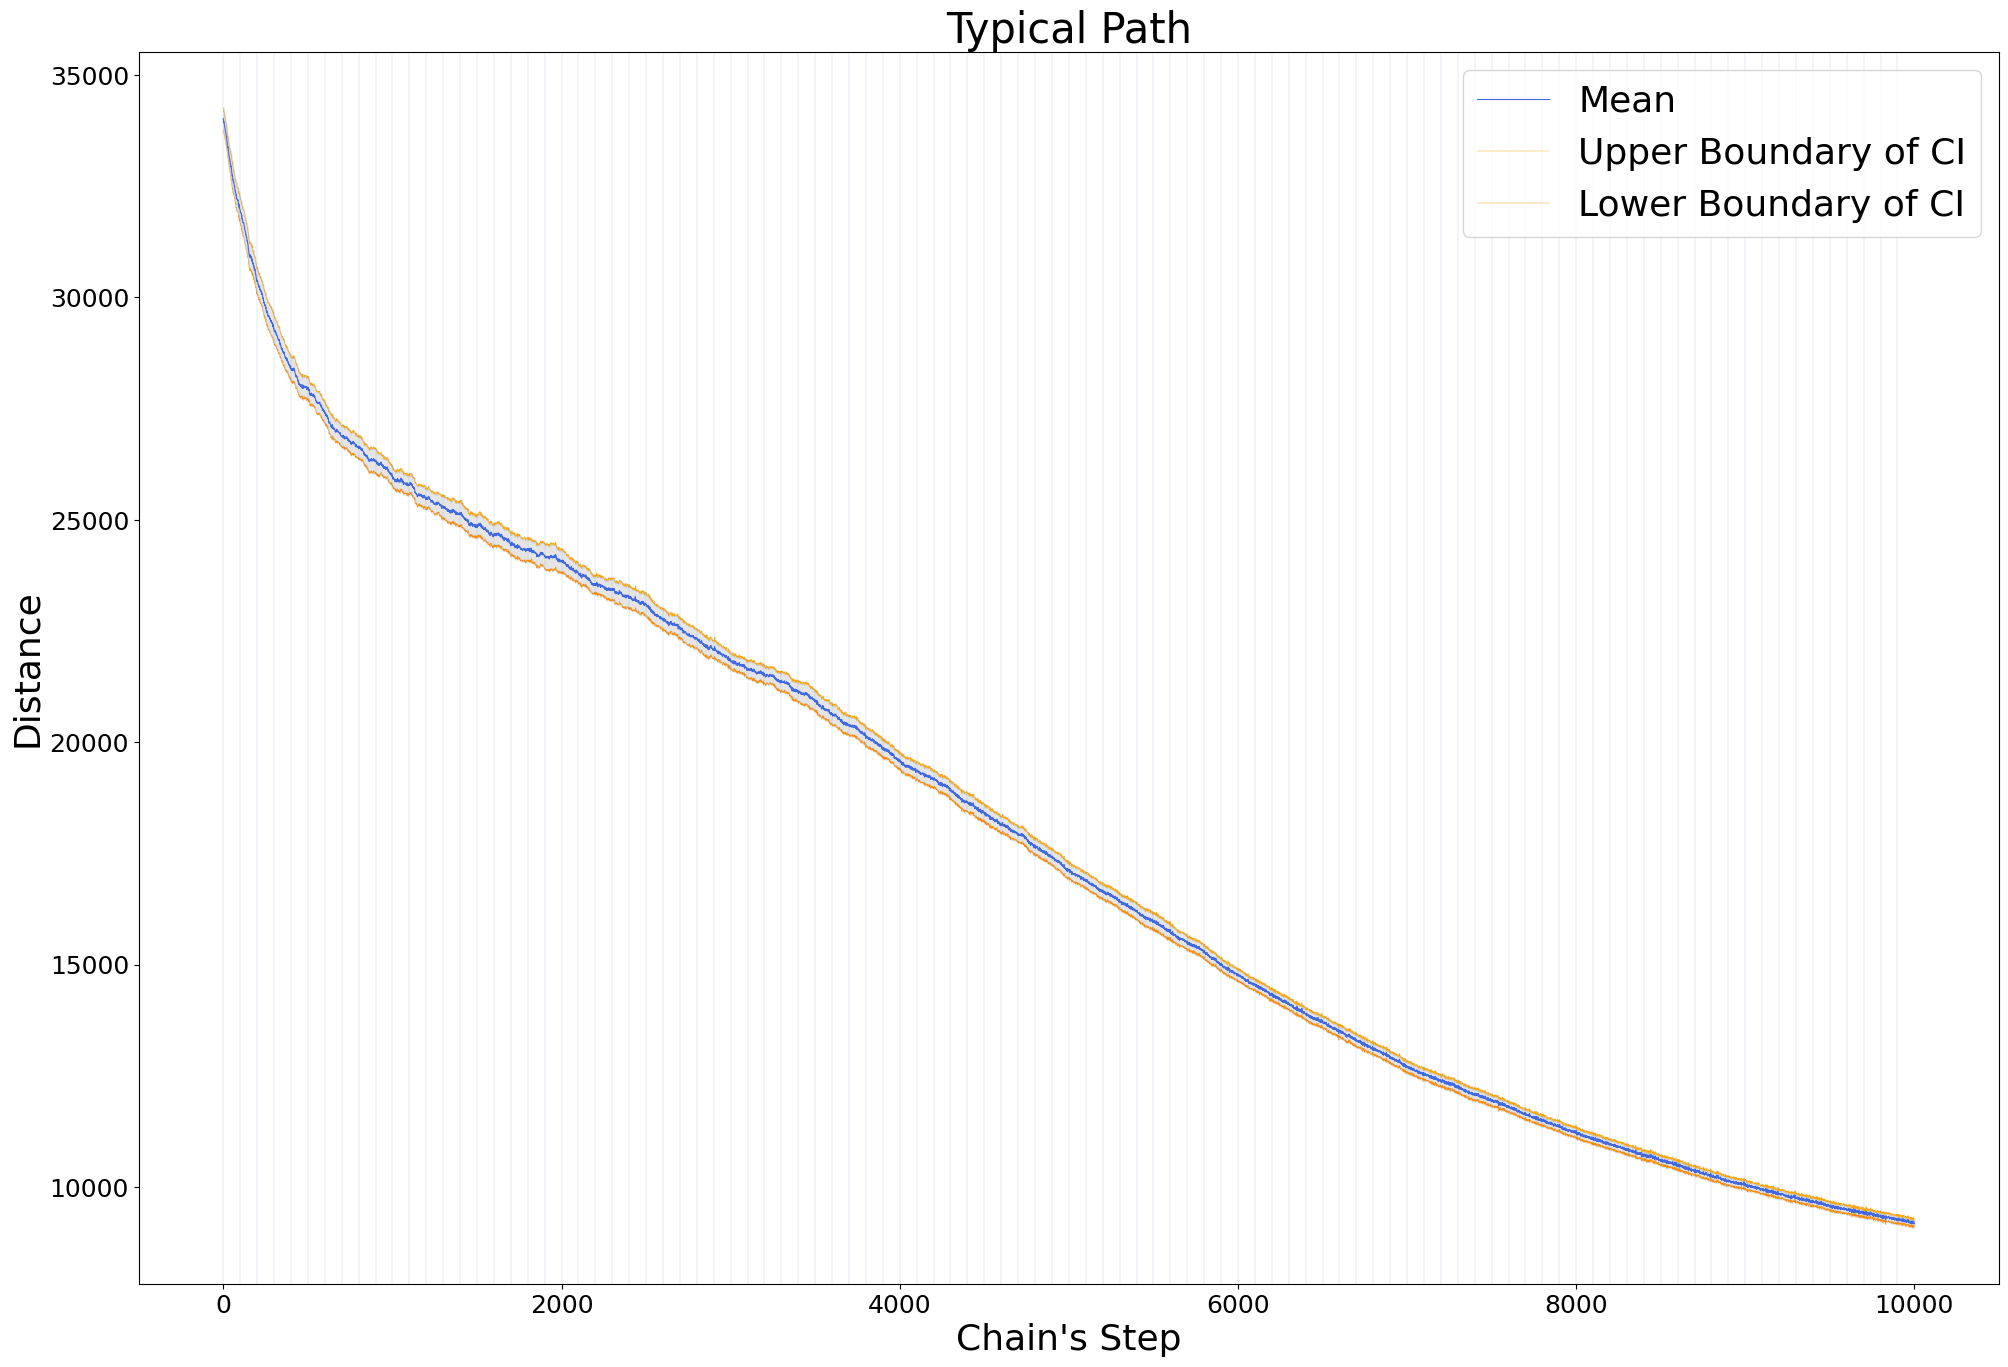

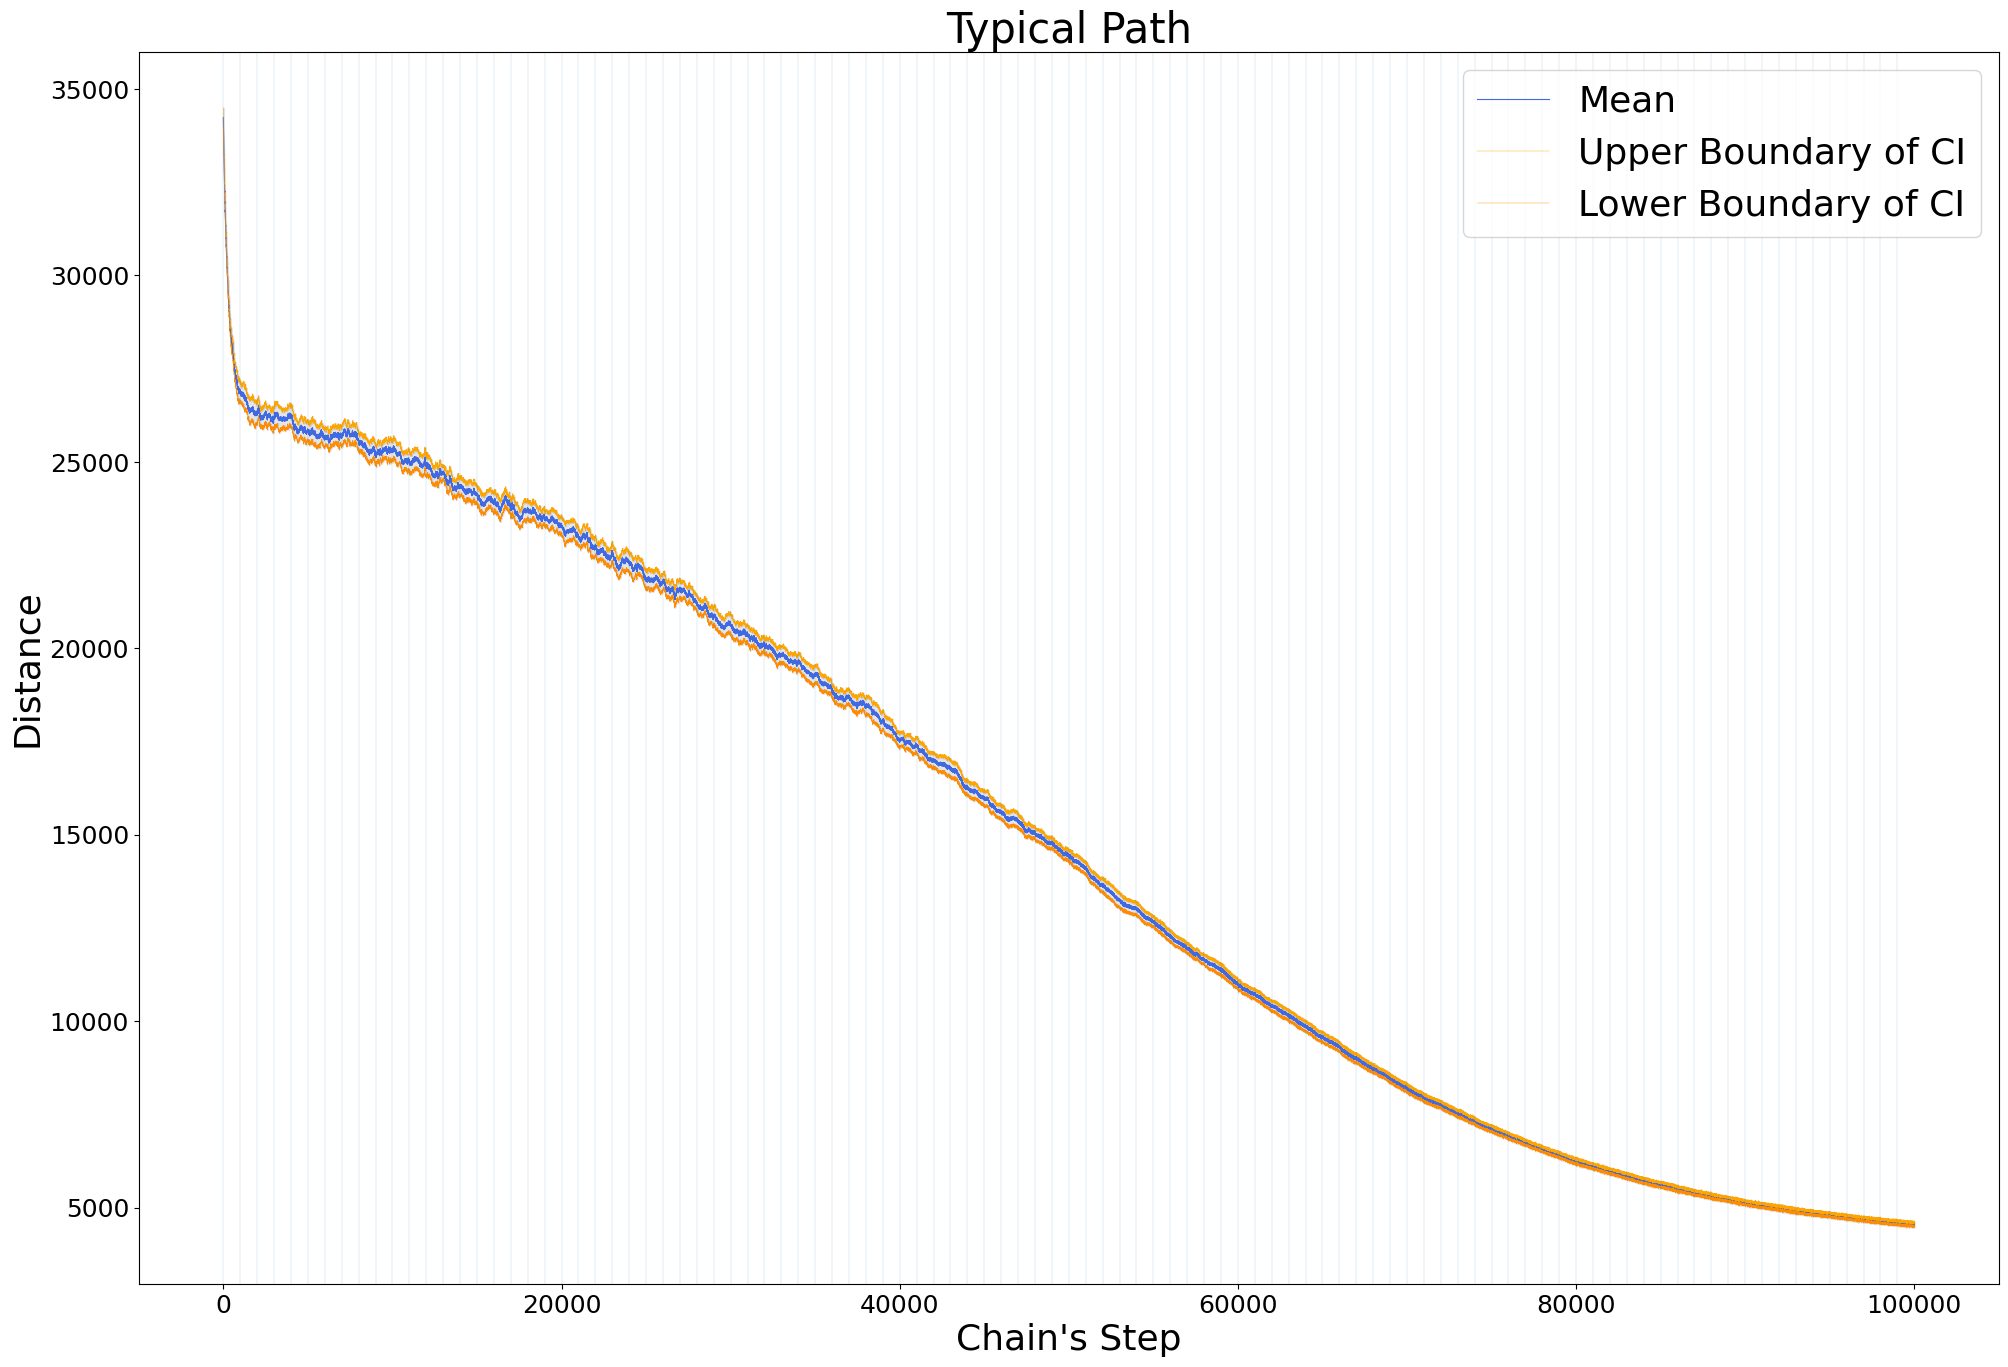

c:\Users\pmchrist\.conda\envs\ABM\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


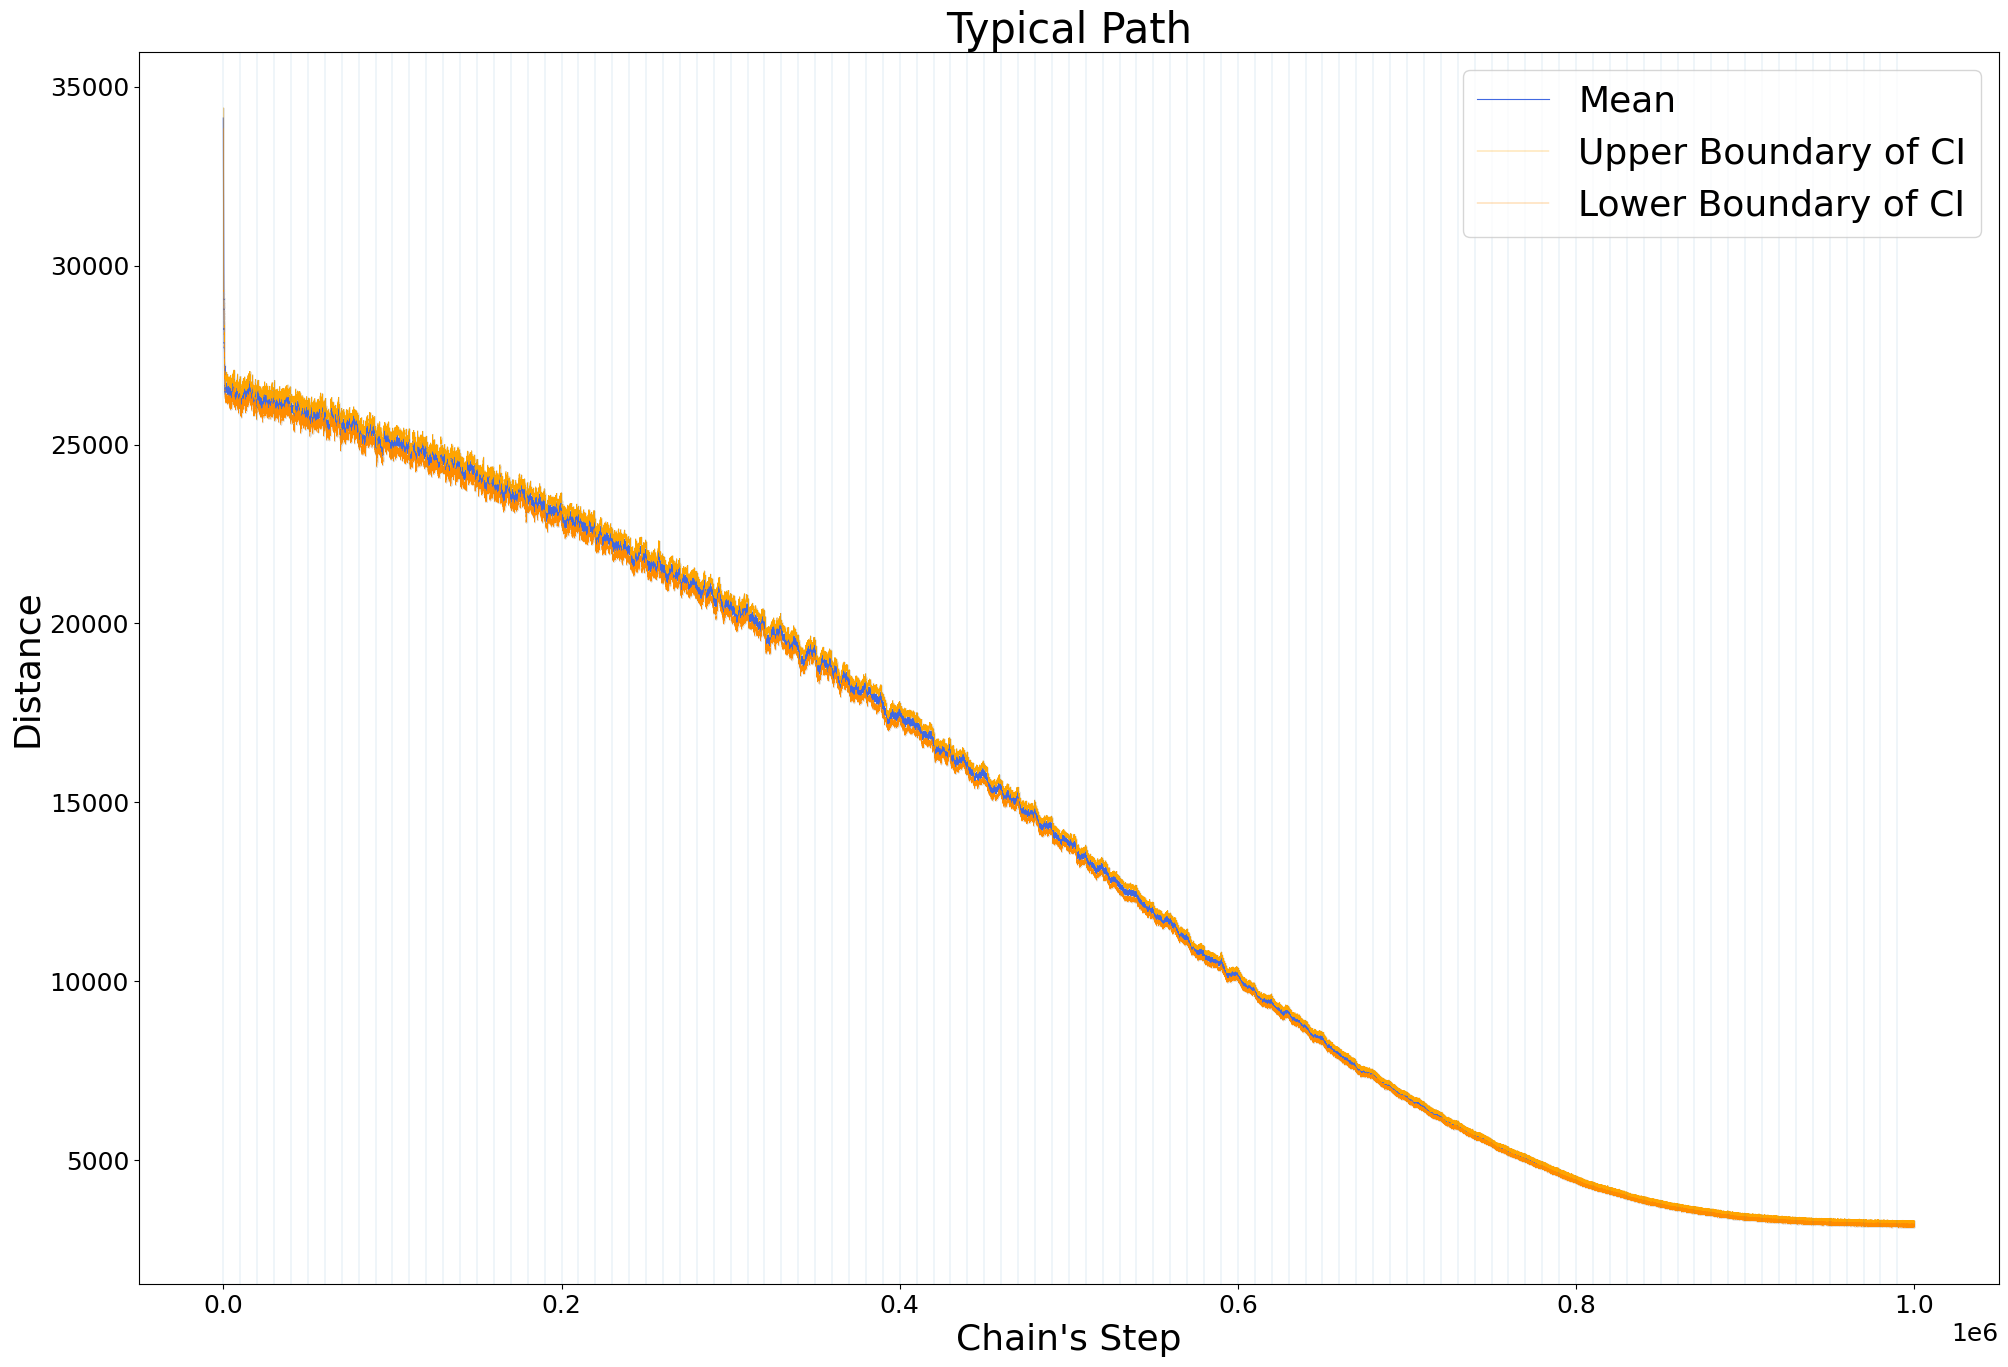

OverflowError: In draw_markers: Exceeded cell block limit

<Figure size 2400x1600 with 1 Axes>

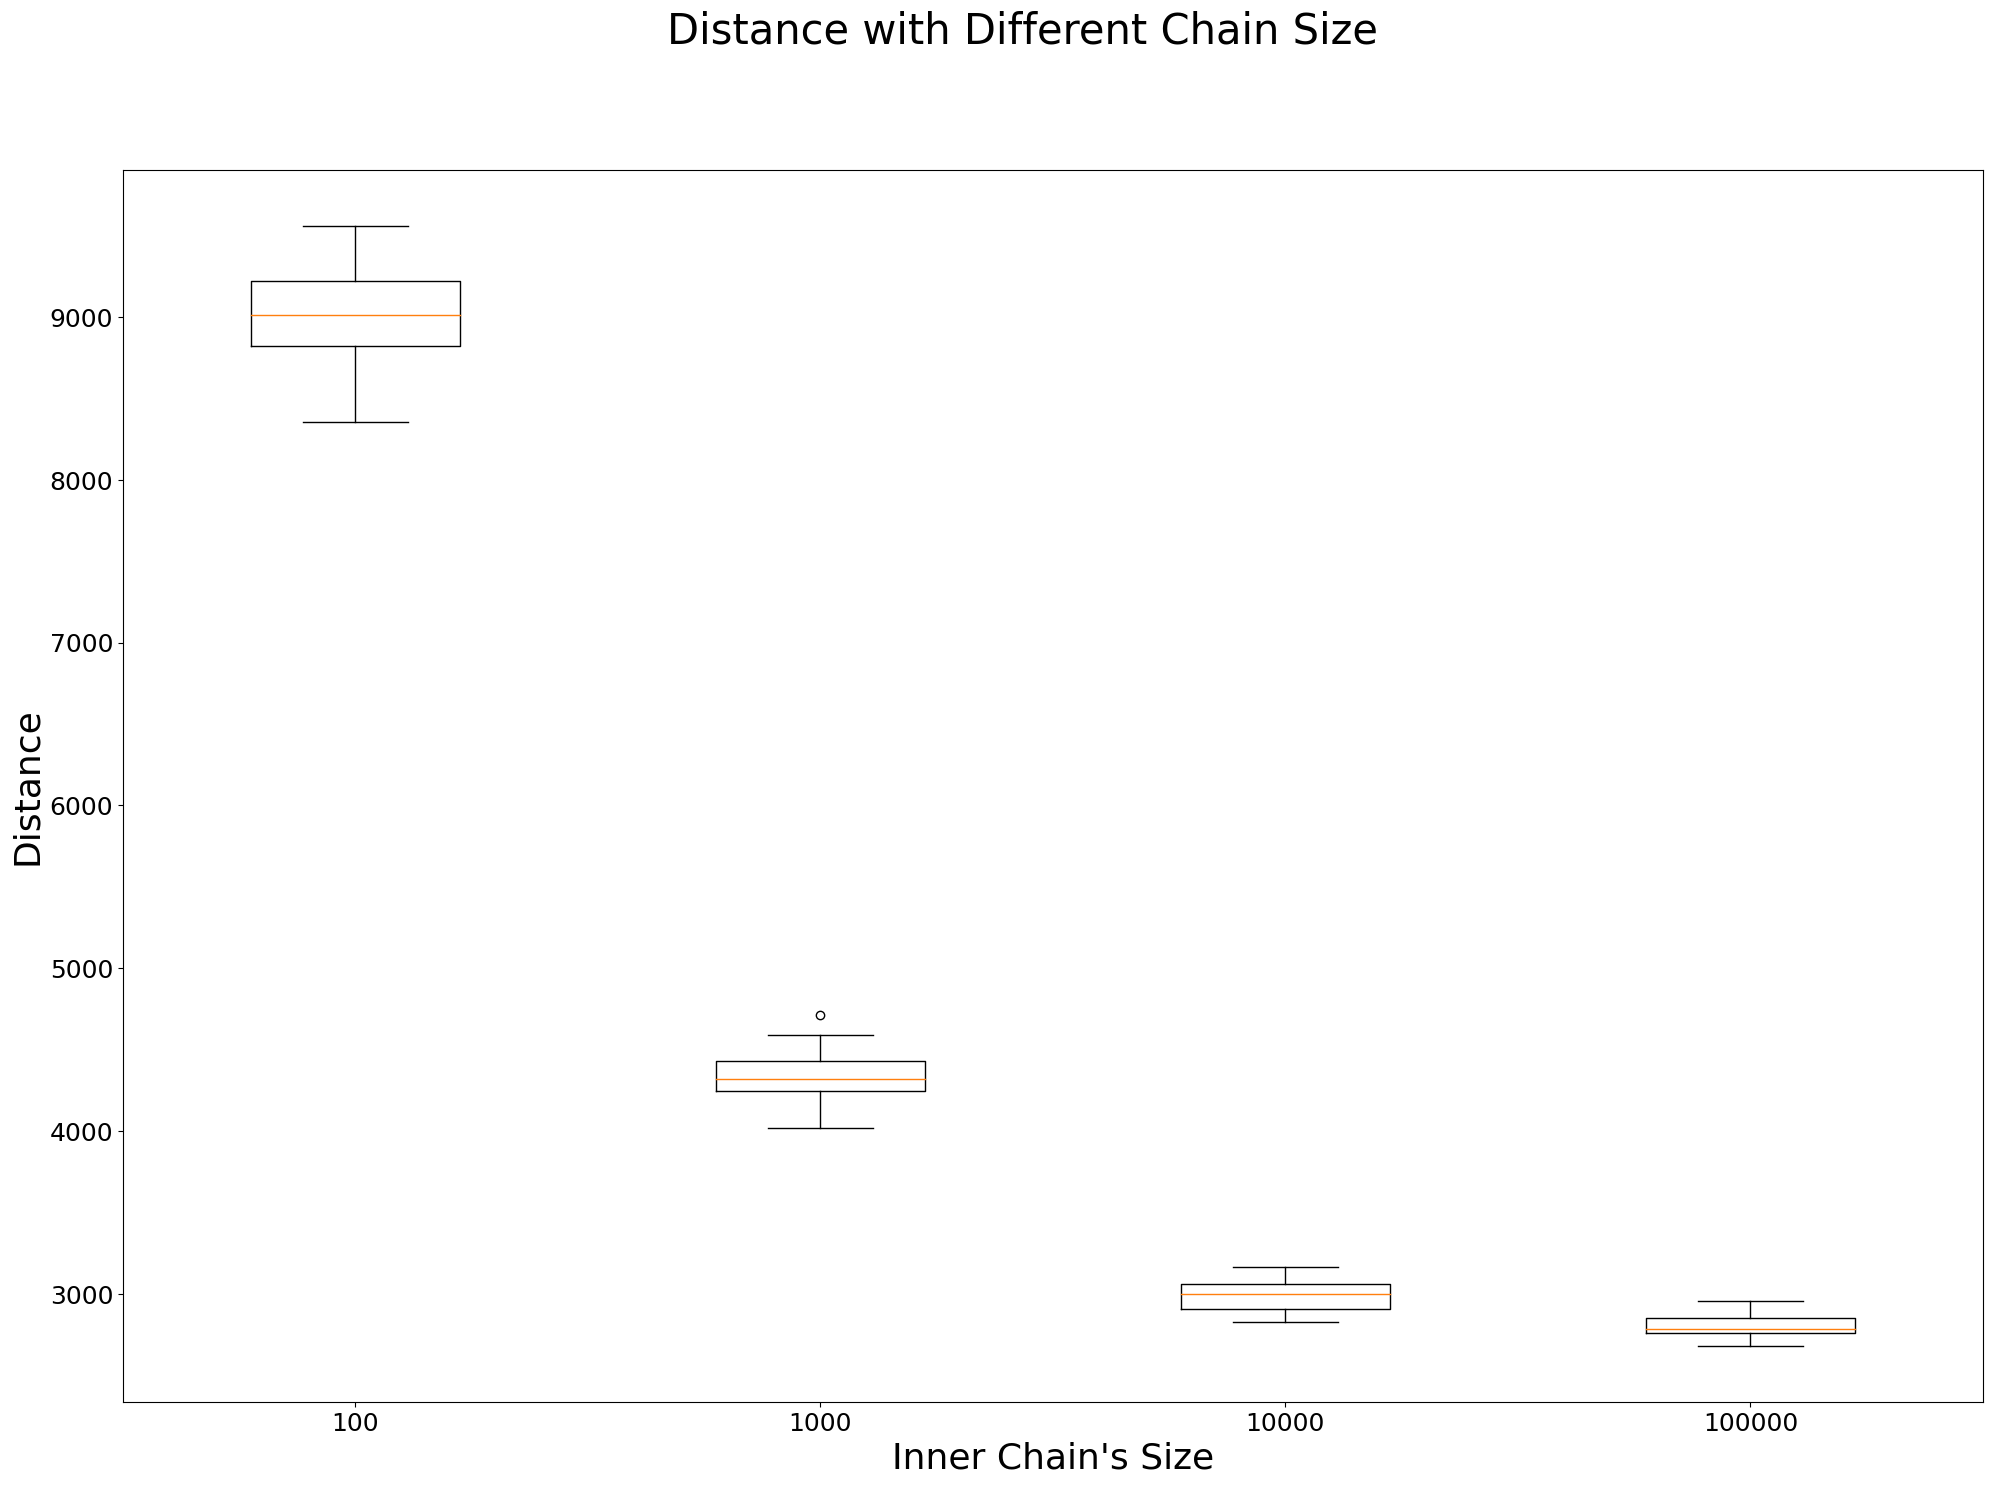

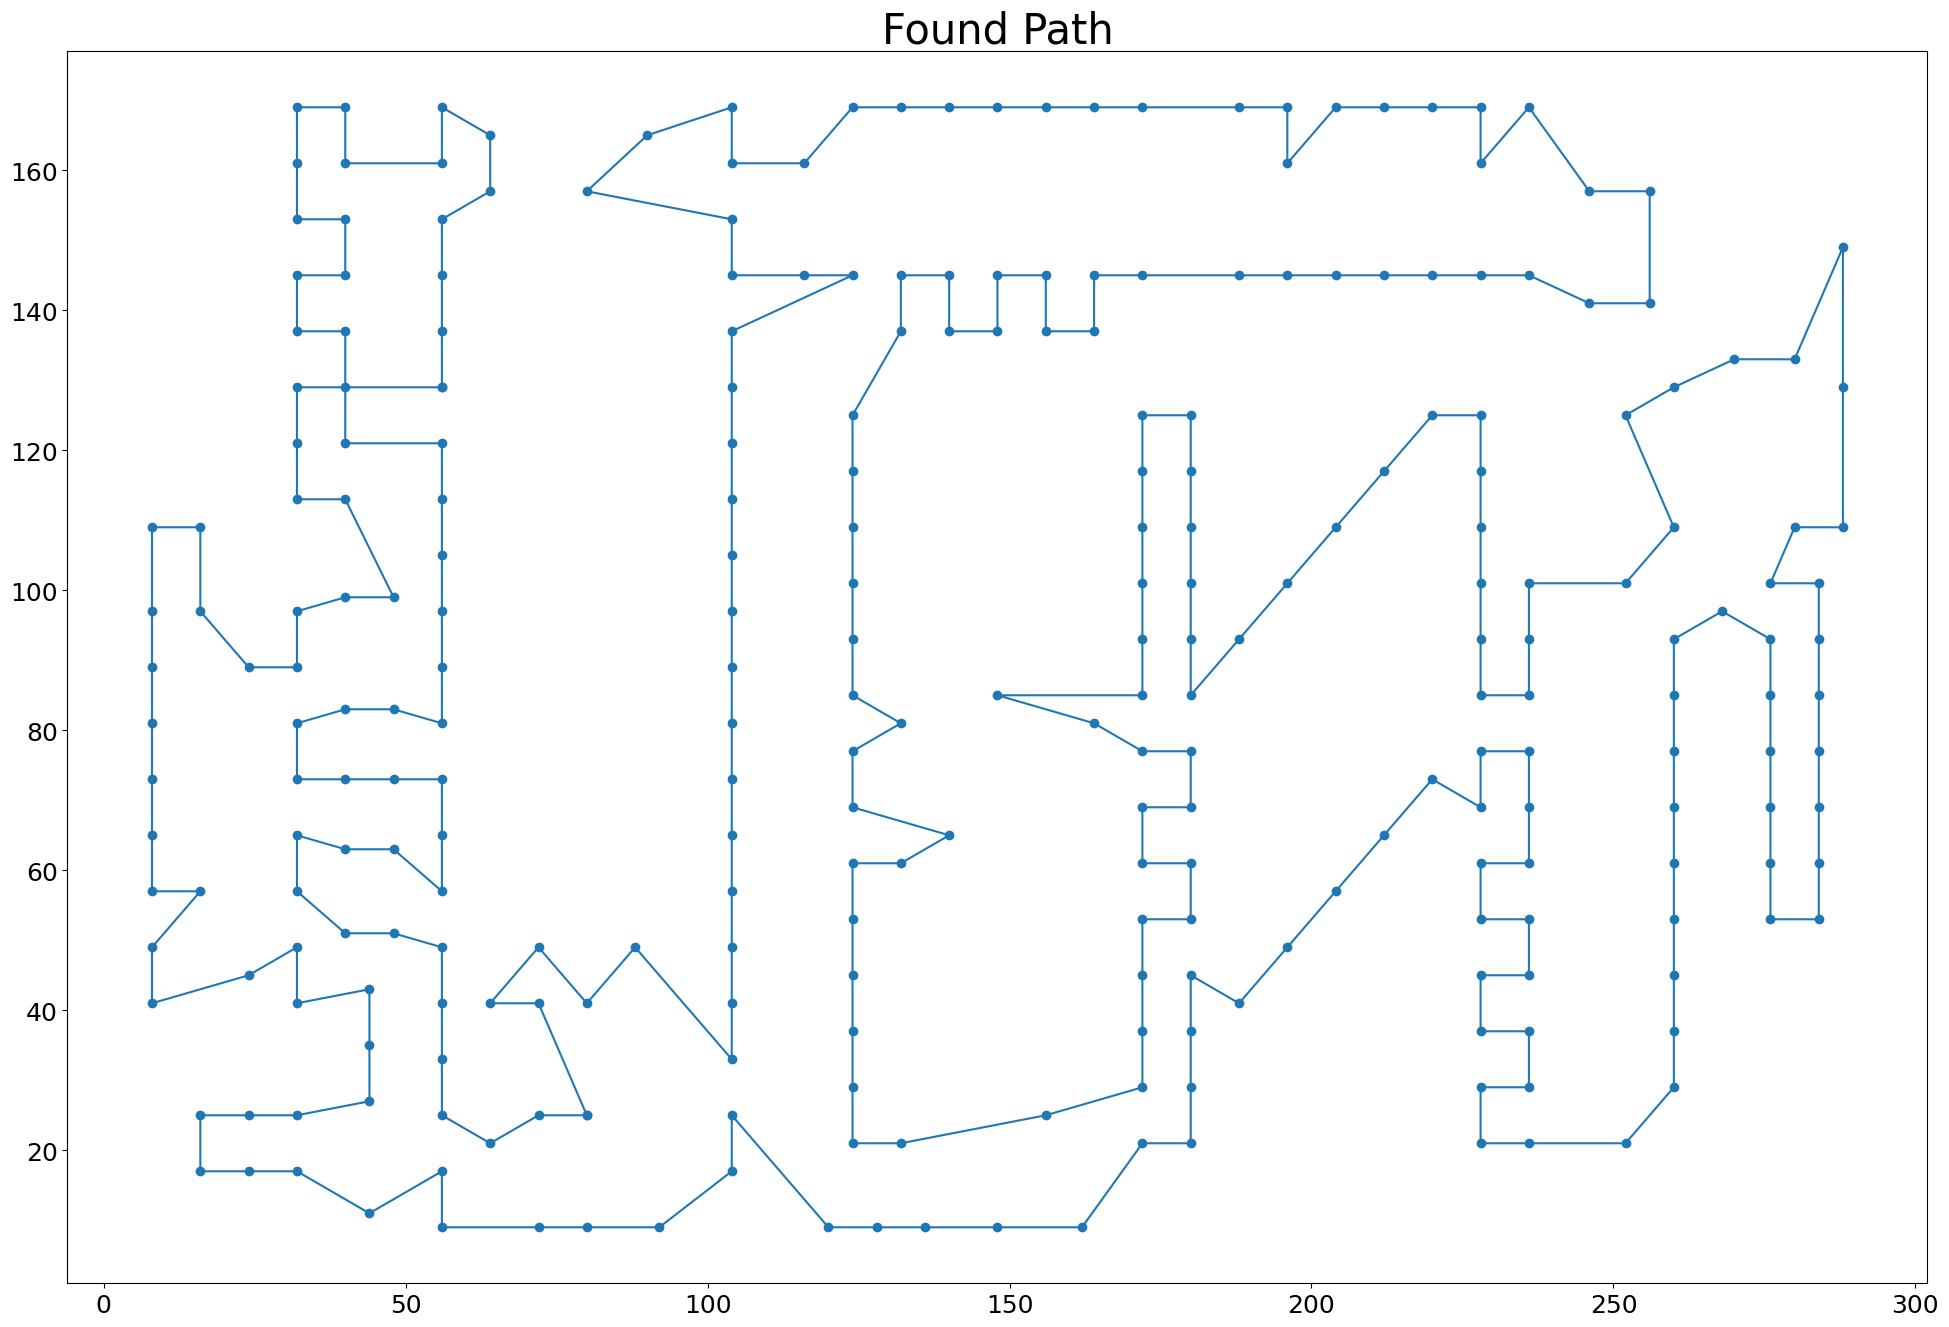

In [17]:
# Generating Solution
mc_chains = 100
mc_chain_sizes = [100, 1000, 10_000, 100_000]

best_solutions = []
the_best_solution = initial_path

for mc_chain_size in mc_chain_sizes:

    history_chain_solutions = []
    history_best_solutions = []
    for i in tqdm(range(CI_SAMPLE_SIZE), desc ="Progress of running samples for CI"):
        best_sol, all_sol = annealing_solution_homogenous("k-opt", 2, generate_initial_random_path(cities), mc_chain_size, mc_chains, "quad", True, False)
        if best_sol.eval_distance() < the_best_solution.eval_distance():
            the_best_solution = best_sol
        history_best_solutions.append(best_sol.eval_distance())
        history_chain_solutions.append(all_sol)

    # For visualization we need to Transpose results to find confidence intervals on each step
    history_chain_solutions_T = np.array(history_chain_solutions).T
    conf_means = []
    conf_stds = []
    for i in tqdm(range(len(history_chain_solutions_T)), desc ="Generating Visualization of Paths"):
        mean, std = confidence_interval(history_chain_solutions_T[i], 0.95, False)
        conf_means.append(mean)
        conf_stds.append(std)

    print("\nBest found paths length: ", confidence_interval(history_best_solutions, 0.95, False))
    visualize_conf_interval(conf_means, conf_stds, "Typical Path", "Chain's Step", "Distance", mc_chains, mc_chain_size)
    best_solutions.append(history_best_solutions)

box_plot(best_solutions, "Distance with Different Chain Size", "Inner Chain's Size", mc_chain_sizes, "Distance")
the_best_solution.visualize()

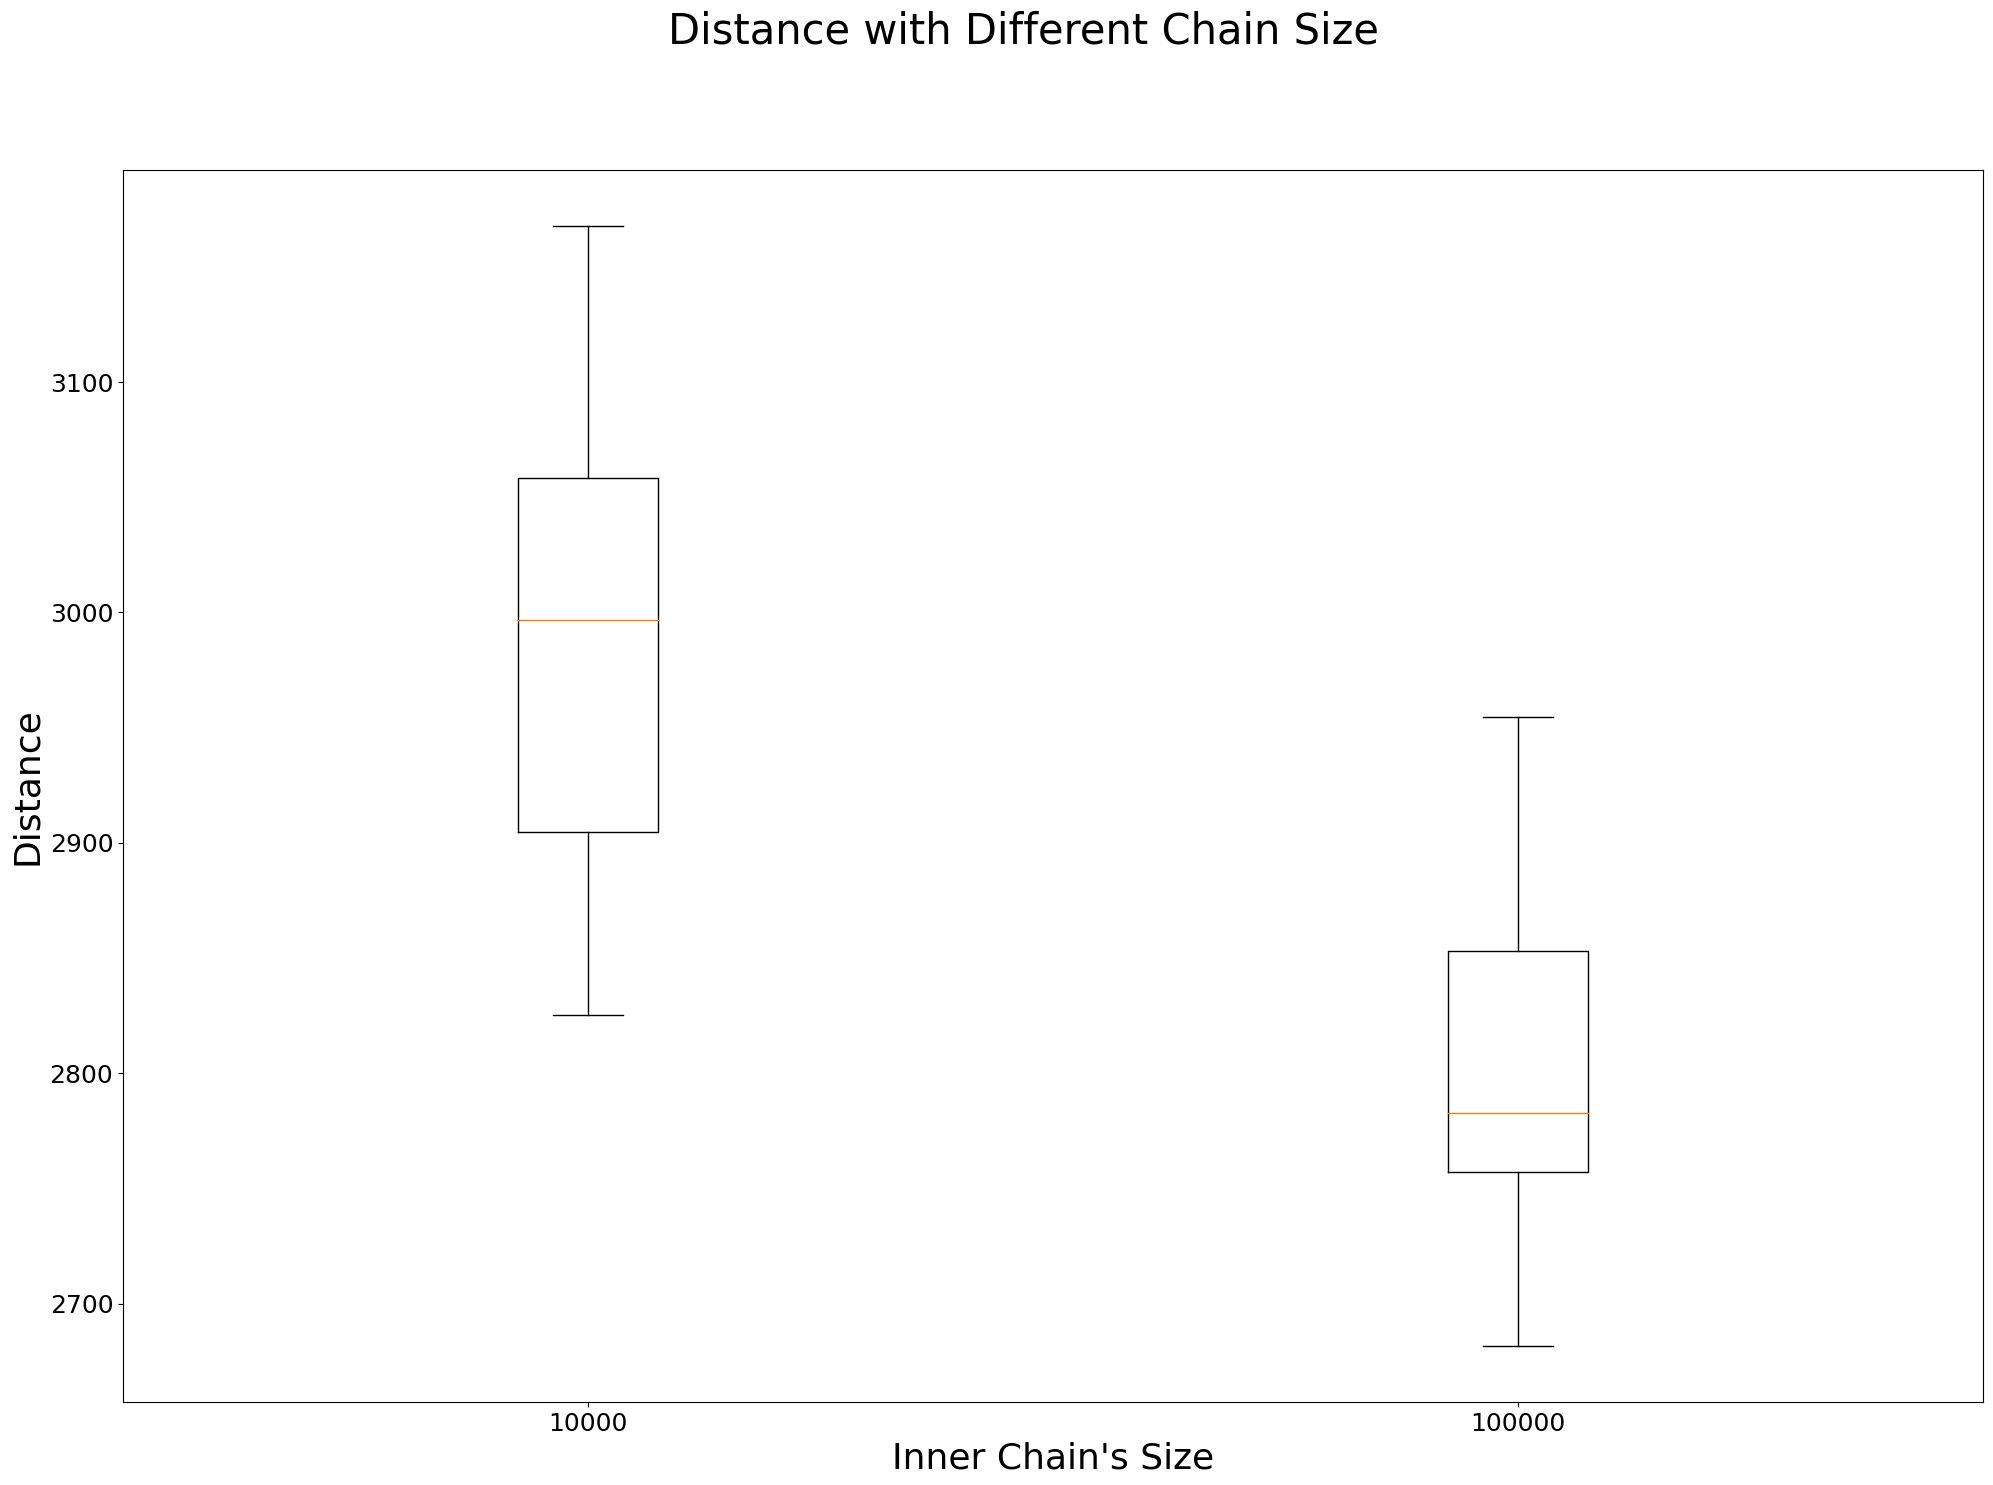

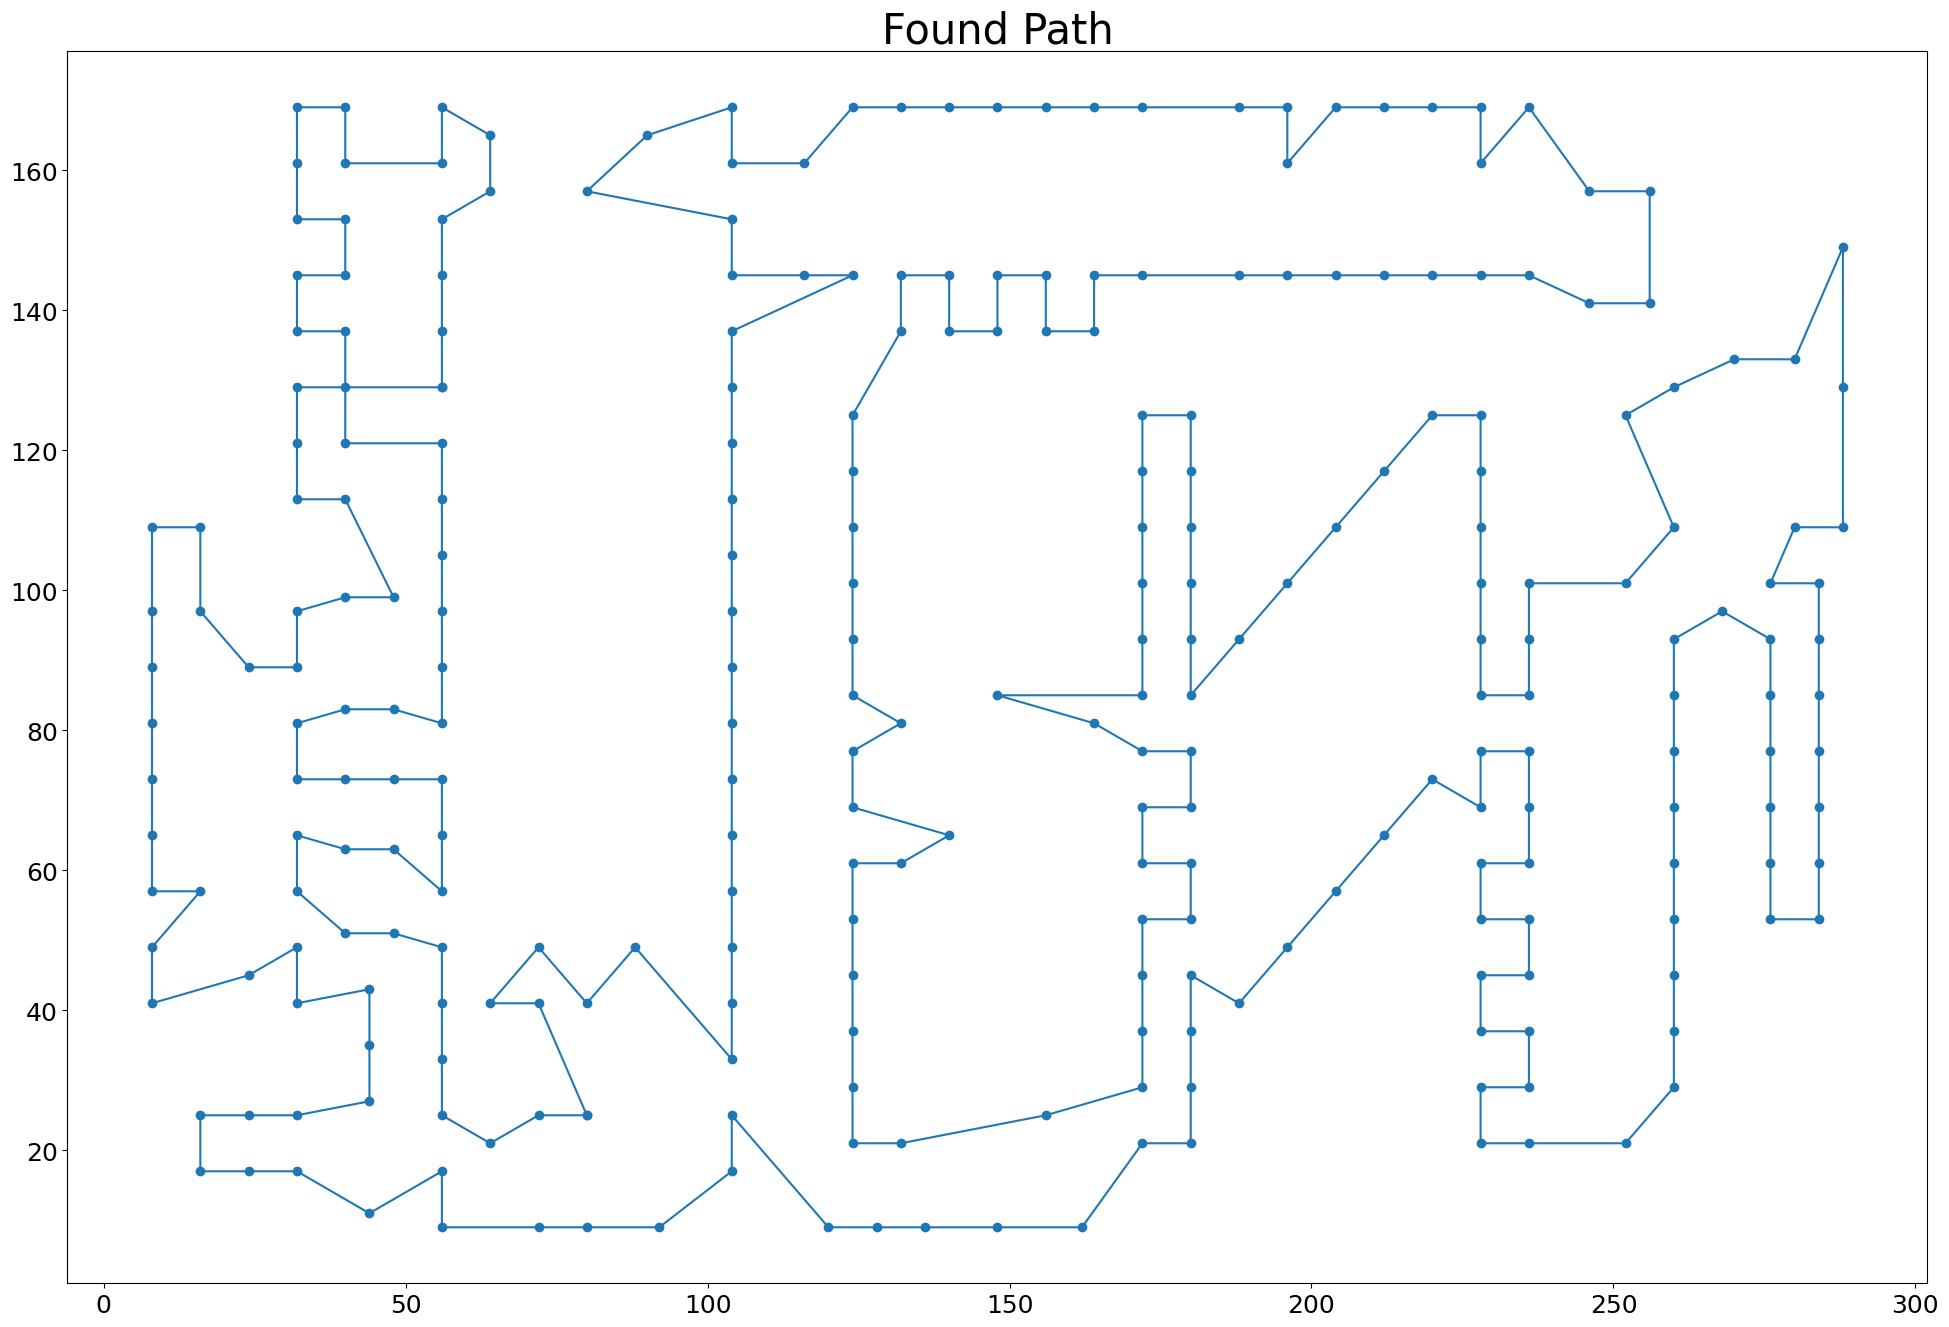

In [19]:
box_plot(best_solutions[2:4], "Distance with Different Chain Size", "Inner Chain's Size", mc_chain_sizes[2:4], "Distance")
the_best_solution.visualize()

# Future Discussions and further optimizations

PreCalculate Distance between all cities and use lookup table

There are so many parameters, it makes this method really complicated to use in real world. To combar this we implemented cooling function without alpha parameter. Yet, still a lot of parameters

We managed to get best solution with both methods. However, it is much more reliable with SA.